### Setting up workspace

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from keras import Sequential, Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
import tensorflow as tf
from pathlib import Path
import pathlib
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input
from keras import utils
import keras
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

In [2]:
kaggle_creden = json.load(open('kaggle.json'))
os.environ['KAGGLE_USERNAME'] = kaggle_creden['username']
os.environ['KAGGLE_KEY'] = kaggle_creden['key']

In [3]:
!kaggle datasets download abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.02G/2.04G [00:01<00:00, 1.53GB/s]
100% 2.04G/2.04G [00:01<00:00, 1.62GB/s]


In [4]:
with ZipFile('plantvillage-dataset.zip', 'r') as zipObj:
   zipObj.extractall()

In [5]:
base_dir = r'/content/plantvillage dataset/color'

In [6]:
img_size = (224, 224)
batch_size = 32

### Data generators

#### Image

In [7]:
Data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [8]:
train_gen = Data_gen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    shuffle=True,
    class_mode='categorical'
)

Found 43456 images belonging to 38 classes.


In [9]:
validation_gen = Data_gen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


In [10]:
Test_gen = Data_gen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    shuffle=True,
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


#### Defining Class Indices (Y:Plant Diseases)

In [11]:
#Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_gen.class_indices.items()}
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

##### Data Sample counts

In [12]:
def get_counts(gen):
  # Reverse the class indices mapping: numeric -> class name
  inv_mapping = {v: k for k, v in gen.class_indices.items()}
  # gen.class is an array of integer labels for each image
  unique, counts = np.unique(gen.classes, return_counts=True)
  # Create a dictionary: class names -> Counts
  return {inv_mapping[i]: count for i, count in zip(unique, counts)}

# Compute counts for each generator
train_counts = get_counts(train_gen)
validation_counts = get_counts(validation_gen)
test_counts = get_counts(Test_gen)

# Combine all the class names (assume same set of classes in each generator)
all_classes = sorted(set(train_counts.keys()) | set(validation_counts.keys()) | set(test_counts.keys()))

# Create a Dataframe with a column for each dataset
df = pd.DataFrame(index=all_classes)
df['Train'] = df.index.map(train_counts)
df['Validation'] = df.index.map(validation_counts)
df['Test'] = df.index.map(test_counts)

print("Data Sample Counts")
df



Data Sample Counts


,Train,Validation,Test
Apple___Apple_scab,504,126,126
Apple___Black_rot,497,124,124
Apple___Cedar_apple_rust,220,55,55
Apple___healthy,1316,329,329
Blueberry___healthy,1202,300,300
Cherry_(including_sour)___Powdery_mildew,842,210,210
Cherry_(including_sour)___healthy,684,170,170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,411,102,102
Corn_(maize)___Common_rust_,954,238,238
Corn_(maize)___Northern_Leaf_Blight,788,197,197


#### Soil

#### Soil Parameters for each plant disease

In [13]:
# 1. Define custom parameter ranges per disease class
class_param_ranges = {
    'Apple___Apple_scab': {
        'pH': (5.0, 6.5),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (15.0, 40.0),
        'potassium': (80.0, 150.0),
        'temperature': (15.0, 22.0),
        'humidity': (70.0, 95.0),
    },
    'Apple___Black_rot': {
        'pH': (5.5, 7.0),
        'moisture': (30.0, 50.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 130.0),
        'temperature': (20.0, 28.0),
        'humidity': (75.0, 95.0),
    },
    'Apple___Cedar_apple_rust': {
        'pH': (5.0, 6.5),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.4),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (18.0, 25.0),
        'humidity': (80.0, 100.0),
    },
    'Apple___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Blueberry___healthy': {
        'pH': (4.5, 5.5),
        'moisture': (20.0, 35.0),
        'nitrogen': (0.1, 0.3),
        'phosphorus': (10.0, 25.0),
        'potassium': (50.0, 100.0),
        'temperature': (15.0, 25.0),
        'humidity': (60.0, 80.0),
    },
    'Cherry_(including_sour)___Powdery_mildew': {
        'pH': (6.0, 7.0),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.4),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (20.0, 28.0),
        'humidity': (70.0, 95.0),
    },
    'Cherry_(including_sour)___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot': {
        'pH': (6.0, 7.5),
        'moisture': (30.0, 50.0),
        'nitrogen': (0.25, 0.5),
        'phosphorus': (15.0, 40.0),
        'potassium': (80.0, 150.0),
        'temperature': (22.0, 30.0),
        'humidity': (75.0, 95.0),
    },
    'Corn_(maize)___Common_rust_': {
        'pH': (6.0, 7.0),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.25, 0.5),
        'phosphorus': (15.0, 40.0),
        'potassium': (80.0, 150.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Corn_(maize)___Northern_Leaf_Blight': {
        'pH': (6.0, 7.5),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 130.0),
        'temperature': (18.0, 26.0),
        'humidity': (70.0, 90.0),
    },
    'Corn_(maize)___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.2, 0.4),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 120.0),
        'temperature': (18.0, 28.0),
        'humidity': (50.0, 70.0),
    },
    'Grape___Black_rot': {
        'pH': (5.5, 7.0),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Grape___Esca_(Black_Measles)': {
        'pH': (5.5, 7.0),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 140.0),
        'temperature': (18.0, 26.0),
        'humidity': (75.0, 95.0),
    },
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': {
        'pH': (5.5, 7.0),
        'moisture': (30.0, 50.0),
        'nitrogen': (0.25, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (80.0, 150.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Grape___healthy': {
        'pH': (5.5, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Orange___Haunglongbing_(Citrus_greening)': {
        'pH': (5.5, 6.5),
        'moisture': (20.0, 40.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (22.0, 32.0),
        'humidity': (70.0, 95.0),
    },
    'Peach___Bacterial_spot': {
        'pH': (6.0, 7.5),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (18.0, 26.0),
        'humidity': (75.0, 95.0),
    },
    'Peach___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Pepper,_bell___Bacterial_spot': {
        'pH': (6.0, 7.5),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 30.0),
        'humidity': (75.0, 95.0),
    },
    'Pepper,_bell___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (18.0, 28.0),
        'humidity': (50.0, 70.0),
    },
    'Potato___Early_blight': {
        'pH': (5.5, 7.0),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Potato___Late_blight': {
        'pH': (5.5, 7.0),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (18.0, 26.0),
        'humidity': (85.0, 100.0),
    },
    'Potato___healthy': {
        'pH': (5.5, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Raspberry___healthy': {
        'pH': (5.5, 6.5),
        'moisture': (20.0, 35.0),
        'nitrogen': (0.1, 0.3),
        'phosphorus': (10.0, 25.0),
        'potassium': (50.0, 100.0),
        'temperature': (15.0, 25.0),
        'humidity': (60.0, 80.0),
    },
    'Soybean___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 120.0),
        'temperature': (20.0, 30.0),
        'humidity': (50.0, 70.0),
    },
    'Squash___Powdery_mildew': {
        'pH': (6.0, 7.5),
        'moisture': (30.0, 50.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 30.0),
        'humidity': (75.0, 95.0),
    },
    'Strawberry___Leaf_scorch': {
        'pH': (5.5, 7.0),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 130.0),
        'temperature': (18.0, 26.0),
        'humidity': (70.0, 90.0),
    },
    'Strawberry___healthy': {
        'pH': (5.5, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (70.0, 130.0),
        'temperature': (15.0, 25.0),
        'humidity': (50.0, 70.0),
    },
    'Tomato___Bacterial_spot': {
        'pH': (6.0, 7.5),
        'moisture': (25.0, 45.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 30.0),
        'humidity': (75.0, 95.0),
    },
    'Tomato___Early_blight': {
        'pH': (6.0, 7.0),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Tomato___Late_blight': {
        'pH': (6.0, 7.0),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.5),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (18.0, 26.0),
        'humidity': (85.0, 100.0),
    },
    'Tomato___Leaf_Mold': {
        'pH': (5.5, 7.0),
        'moisture': (35.0, 60.0),
        'nitrogen': (0.25, 0.5),
        'phosphorus': (15.0, 40.0),
        'potassium': (80.0, 160.0),
        'temperature': (22.0, 30.0),
        'humidity': (85.0, 100.0),
    },
    'Tomato___Septoria_leaf_spot': {
        'pH': (6.0, 7.5),
        'moisture': (30.0, 55.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 100.0),
    },
    'Tomato___Spider_mites_Two-spotted_spider_mite': {
        'pH': (6.0, 7.5),
        'moisture': (20.0, 40.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (25.0, 35.0),
        'humidity': (50.0, 80.0),
    },
    'Tomato___Target_Spot': {
        'pH': (5.5, 7.0),
        'moisture': (25.0, 50.0),
        'nitrogen': (0.2, 0.45),
        'phosphorus': (10.0, 35.0),
        'potassium': (70.0, 140.0),
        'temperature': (20.0, 28.0),
        'humidity': (80.0, 95.0),
    },
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.2, 0.4),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (25.0, 35.0),
        'humidity': (30.0, 60.0),
    },
    'Tomato___Tomato_mosaic_virus': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.2, 0.4),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (25.0, 35.0),
        'humidity': (30.0, 60.0),
    },
    'Tomato___healthy': {
        'pH': (6.0, 7.5),
        'moisture': (15.0, 30.0),
        'nitrogen': (0.15, 0.35),
        'phosphorus': (10.0, 30.0),
        'potassium': (60.0, 120.0),
        'temperature': (18.0, 28.0),
        'humidity': (40.0, 70.0),
    },
}

#### Generating soil data

In [14]:
# Generator function using per-class ranges
def soildata_generator(
    train_gen, validation_gen, Test_gen,
                       class_param_ranges,
                       default_ranges= None,
                       random_state= 42
):
  rng = np.random.default_rng(random_state)
  if default_ranges is None:
    default_ranges = {
        'pH': (4.0,9.0),
        'moisture': (5.0,40.0),
        'nitrogen': (0.1,0.5),
        'phosphorus': (5.0,50.0),
        'potassium': (50.0,200.0),
        'temperature': (10.0,35.0),
        'humidity': (30.0,90.0)
    }
  # Invert class indices to class names
  inv_mapping = {v: k for k, v in train_gen.class_indices.items()}
  def make_df(gen):
    labels = gen.classes
    unique, counts = np.unique(labels, return_counts=True)
    rows =[]
    for cls, cnt in zip(unique, counts):
      cname = inv_mapping[cls]
      ranges = class_param_ranges.get(cname, default_ranges)
      samples = {params: rng.uniform(lo,hi, cnt) for params, (lo, hi) in ranges.items()}
      df_part = pd.DataFrame(samples)
      df_part['label'] = cname
      rows.append(df_part)
    return pd.concat(rows, ignore_index=True)
  return make_df(train_gen), make_df(validation_gen), make_df(Test_gen)

In [15]:
train_df, validation_df, test_df = soildata_generator(
    train_gen, validation_gen, Test_gen,
    class_param_ranges,
    default_ranges= None,
    random_state= 42
)

display(train_df)
display(validation_df)
display(test_df)

,pH,moisture,nitrogen,phosphorus,potassium,temperature,humidity,label
0,6.160934,35.405502,0.417854,30.670625,99.574543,16.142447,77.853872,Apple___Apple_scab
1,5.658318,40.997408,0.338330,33.681745,82.243051,18.943214,73.532232,Apple___Apple_scab
2,6.287897,31.289014,0.397985,37.367197,123.007027,17.576653,76.673341,Apple___Apple_scab
3,6.046052,41.747647,0.379909,21.814662,106.160260,19.383115,91.492008,Apple___Apple_scab
4,5.141266,34.882833,0.341835,17.768106,125.593450,21.385437,85.060424,Apple___Apple_scab
...,...,...,...,...,...,...,...,...
43451,6.011482,23.219095,0.272653,22.735731,97.452890,18.652935,60.797979,Tomato___healthy
43452,6.679098,15.658004,0.167574,13.674221,104.503838,19.183271,68.741282,Tomato___healthy
43453,7.362908,20.861562,0.285053,24.280626,80.527710,18.563999,64.163385,Tomato___healthy
43454,6.170828,28.007780,0.189429,28.953184,105.313308,21.989172,62.202969,Tomato___healthy


,pH,moisture,nitrogen,phosphorus,potassium,temperature,humidity,label
0,5.242377,32.156202,0.480070,34.139871,95.170508,21.022053,71.593696,Apple___Apple_scab
1,5.084598,33.357692,0.292666,18.293485,132.904195,16.555609,87.849138,Apple___Apple_scab
2,5.719968,39.039603,0.262775,31.073163,98.003544,15.637474,87.312448,Apple___Apple_scab
3,6.423668,40.383444,0.257128,24.160417,90.398416,15.911041,90.006425,Apple___Apple_scab
4,6.470213,25.805159,0.454375,31.097786,93.863073,15.337567,90.847309,Apple___Apple_scab
...,...,...,...,...,...,...,...,...
10844,6.232983,20.201511,0.300120,18.433667,77.290285,27.955971,51.614999,Tomato___healthy
10845,6.468137,16.784388,0.151366,11.685296,80.520779,27.178577,41.827844,Tomato___healthy
10846,6.584802,25.348130,0.244920,11.608647,73.710634,25.444743,66.104775,Tomato___healthy
10847,7.303705,19.943033,0.265609,12.037407,83.481501,22.896596,67.010851,Tomato___healthy


,pH,moisture,nitrogen,phosphorus,potassium,temperature,humidity,label
0,5.531757,30.197228,0.372265,26.700324,131.485668,21.933616,84.464867,Apple___Apple_scab
1,6.311585,38.251147,0.436671,38.471492,130.996328,15.580367,75.505137,Apple___Apple_scab
2,5.059788,39.420508,0.484976,32.507523,91.490961,21.747191,90.556048,Apple___Apple_scab
3,6.150854,39.117708,0.282842,31.086670,93.769009,21.079819,90.421010,Apple___Apple_scab
4,6.237219,44.815162,0.395786,19.854473,82.258091,16.966781,87.664374,Apple___Apple_scab
...,...,...,...,...,...,...,...,...
10844,6.482375,26.237248,0.253695,16.225040,107.456609,20.579261,41.752742,Tomato___healthy
10845,7.309785,23.702178,0.270598,11.687726,61.737171,23.129720,46.822934,Tomato___healthy
10846,6.030428,19.143394,0.241596,22.344335,109.495902,18.304017,47.310104,Tomato___healthy
10847,6.679407,19.590681,0.281744,14.166614,80.788700,25.944401,55.442748,Tomato___healthy


In [16]:
def addPlant(df):
  df = df.copy()
  df['Plant'] = df['label'].str.split('___').str[0]
  return df

In [17]:
train_df = addPlant(train_df)
validation_df = addPlant(validation_df)
test_df = addPlant(test_df)

In [18]:
x_train_soil = train_df.drop(columns=['label'])
y_train_soil = train_df['label']

x_val_soil = validation_df.drop(columns=['label'])
y_val_soil = validation_df['label']

x_test_soil = test_df.drop(columns=['label'])
y_test_soil = test_df['label']

In [19]:
le = LabelEncoder()
y_train_soil = le.fit_transform(y_train_soil)
y_val_soil = le.transform(y_val_soil)
y_test_soil = le.transform(y_test_soil)
x_test_soil['Plant'] = le.fit_transform(x_test_soil['Plant'])
x_train_soil['Plant'] = le.transform(x_train_soil['Plant'])
x_val_soil['Plant'] = le.transform(x_val_soil['Plant'])

In [20]:
x_train_soil.shape, y_train_soil.shape, x_val_soil.shape, y_val_soil.shape, x_test_soil.shape, y_test_soil.shape

((43456, 8), (43456,), (10849, 8), (10849,), (10849, 8), (10849,))

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_soil = scaler.fit_transform(x_train_soil)
x_val_soil = scaler.transform(x_val_soil)
x_test_soil = scaler.transform(x_test_soil)

#### Weather

#### Weather Parameters

In [22]:
timesteps = 168
n_classes = 38
n_features = 11

In [23]:
# disease list
DISEASE_LIST = [
  'Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
  'Blueberry___healthy','Cherry_(including_sour)___Powdery_mildew','Cherry_(including_sour)___healthy',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_','Corn_(maize)___Northern_Leaf_Blight',
  'Corn_(maize)___healthy','Grape___Black_rot','Grape___Esca_(Black_Measles)','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
  'Grape___healthy','Orange___Haunglongbing_(Citrus_greening)','Peach___Bacterial_spot','Peach___healthy',
  'Pepper,_bell___Bacterial_spot','Pepper,_bell___healthy','Potato___Early_blight','Potato___Late_blight',
  'Potato___healthy','Raspberry___healthy','Soybean___healthy','Squash___Powdery_mildew','Strawberry___Leaf_scorch',
  'Strawberry___healthy','Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight','Tomato___Leaf_Mold',
  'Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot',
  'Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus','Tomato___healthy'
]
DISEASE_TO_ID = {name: i for i, name in enumerate(DISEASE_LIST)}

In [24]:
def parse_disease_name(disease_name):
    """Extract plant type and disease type from disease name"""
    parts = disease_name.split('___')
    if len(parts) == 2:
        plant_type = parts[0].strip()
        disease_type = parts[1].strip()
        return plant_type, disease_type
    return disease_name, "unknown"

# Base weather profiles for each plant type (healthy growing conditions)
BASE_PLANT_PROFILES = {
    'Apple': {
        'temp_range': (18, 24),         # °C - optimal growing range
        'humidity_base': 65,            # % - moderate humidity
        'soil_moisture_target': 0.25,   # m3/m3 - well-drained but moist
        'temp_tolerance': 3,            # °C - temperature variation tolerance
    },
    'Tomato': {
        'temp_range': (20, 26),
        'humidity_base': 70,
        'soil_moisture_target': 0.30,
        'temp_tolerance': 2,
    },
    'Corn_(maize)': {
        'temp_range': (22, 28),
        'humidity_base': 60,
        'soil_moisture_target': 0.35,
        'temp_tolerance': 4,
    },
    'Potato': {
        'temp_range': (16, 22),
        'humidity_base': 75,
        'soil_moisture_target': 0.28,
        'temp_tolerance': 2,
    },
    'Grape': {
        'temp_range': (20, 25),
        'humidity_base': 60,
        'soil_moisture_target': 0.20,
        'temp_tolerance': 3,
    },
    'Peach': {
        'temp_range': (21, 27),
        'humidity_base': 65,
        'soil_moisture_target': 0.25,
        'temp_tolerance': 3,
    },
    'Cherry_(including_sour)': {
        'temp_range': (18, 24),
        'humidity_base': 68,
        'soil_moisture_target': 0.22,
        'temp_tolerance': 3,
    },
    'Strawberry': {
        'temp_range': (18, 24),
        'humidity_base': 70,
        'soil_moisture_target': 0.30,
        'temp_tolerance': 2,
    },
    'Pepper,_bell': {
        'temp_range': (21, 27),
        'humidity_base': 65,
        'soil_moisture_target': 0.28,
        'temp_tolerance': 2,
    },
    'Squash': {
        'temp_range': (20, 26),
        'humidity_base': 70,
        'soil_moisture_target': 0.32,
        'temp_tolerance': 3,
    },
    'Orange': {
        'temp_range': (24, 30),
        'humidity_base': 60,
        'soil_moisture_target': 0.25,
        'temp_tolerance': 4,
    },
    'Soybean': {
        'temp_range': (22, 28),
        'humidity_base': 65,
        'soil_moisture_target': 0.30,
        'temp_tolerance': 3,
    },
    'Raspberry': {
        'temp_range': (18, 23),
        'humidity_base': 72,
        'soil_moisture_target': 0.28,
        'temp_tolerance': 2,
    },
    'Blueberry': {
        'temp_range': (16, 22),
        'humidity_base': 75,
        'soil_moisture_target': 0.35,
        'temp_tolerance': 2,
    }
}

# Disease modification rules (pathogen-friendly modifications)
DISEASE_MODIFICATIONS = {
    'healthy': {
        # No modifications - use base profile
        'humidity_shift': 0,
        'temp_stress_factor': 1.0,
        'moisture_shift': 0,
        'leaf_wetness_boost': 0,
    },
    # Fungal diseases - love moisture and moderate temps
    'blight': {
        'humidity_shift': +8,           # Higher humidity
        'temp_stress_factor': 0.8,     # More temperature variation (stress)
        'moisture_shift': +0.08,       # More soil moisture
        'leaf_wetness_boost': +6,      # More leaf wetness hours
    },
    'rust': {
        'humidity_shift': +10,
        'temp_stress_factor': 0.7,
        'moisture_shift': +0.06,
        'leaf_wetness_boost': +8,
    },
    'rot': {
        'humidity_shift': +12,
        'temp_stress_factor': 0.6,
        'moisture_shift': +0.10,
        'leaf_wetness_boost': +10,
    },
    'scab': {
        'humidity_shift': +6,
        'temp_stress_factor': 0.8,
        'moisture_shift': +0.05,
        'leaf_wetness_boost': +5,
    },
    'mildew': {
        'humidity_shift': +15,
        'temp_stress_factor': 0.7,
        'moisture_shift': +0.08,
        'leaf_wetness_boost': +12,
    },
    # Bacterial diseases - also like moisture but different patterns
    'spot': {
        'humidity_shift': +5,
        'temp_stress_factor': 0.9,
        'moisture_shift': +0.04,
        'leaf_wetness_boost': +4,
    },
    # Viral diseases - stress conditions
    'virus': {
        'humidity_shift': -2,
        'temp_stress_factor': 0.5,     # High stress
        'moisture_shift': -0.02,
        'leaf_wetness_boost': +2,
    },
    'mosaic': {
        'humidity_shift': -3,
        'temp_stress_factor': 0.6,
        'moisture_shift': -0.03,
        'leaf_wetness_boost': +1,
    }
}

In [25]:
def get_disease_category(disease_type):
    """Categorize disease type into modification groups"""
    disease_lower = disease_type.lower()

    # Check for specific disease patterns
    for category in DISEASE_MODIFICATIONS.keys():
        if category in disease_lower:
            return category

    # Default categorization based on keywords
    if any(keyword in disease_lower for keyword in ['blight', 'early_blight', 'late_blight']):
        return 'blight'
    elif any(keyword in disease_lower for keyword in ['rust', 'cedar_apple_rust', 'common_rust']):
        return 'rust'
    elif any(keyword in disease_lower for keyword in ['rot', 'black_rot']):
        return 'rot'
    elif any(keyword in disease_lower for keyword in ['spot', 'bacterial_spot', 'leaf_spot']):
        return 'spot'
    elif any(keyword in disease_lower for keyword in ['mildew', 'powdery_mildew']):
        return 'mildew'
    elif any(keyword in disease_lower for keyword in ['virus', 'mosaic']):
        return 'virus'
    elif 'healthy' in disease_lower:
        return 'healthy'
    else:
        return 'spot'  # Default to bacterial-like conditions

In [26]:
def build_targeted_hourly_weather(start_dt: datetime, end_dt: datetime,
                                 plant_type: str, disease_type: str, seed=42) -> pd.DataFrame:
    """
    Build hourly weather data tailored to specific plant-disease combinations
    """
    np.random.seed(seed)
    hours = int((end_dt - start_dt).total_seconds() // 3600)
    timestamps = [start_dt + timedelta(hours=i) for i in range(hours)]
    hour_of_day = np.array([t.hour for t in timestamps])

    # Get base plant profile
    plant_profile = BASE_PLANT_PROFILES.get(plant_type, BASE_PLANT_PROFILES['Tomato'])

    # Get disease modifications
    disease_category = get_disease_category(disease_type)
    disease_mods = DISEASE_MODIFICATIONS.get(disease_category, DISEASE_MODIFICATIONS['healthy'])

    # Build temperature with plant-specific ranges and disease stress
    temp_min, temp_max = plant_profile['temp_range']
    temp_center = (temp_min + temp_max) / 2
    temp_tolerance = plant_profile['temp_tolerance'] * disease_mods['temp_stress_factor']

    # Daily temperature cycle with plant-specific center and disease-induced stress
    temp_daily = temp_center + (temp_max - temp_center) * 0.7 * np.sin((hour_of_day - 6) / 24 * 2 * np.pi)
    air_temp = temp_daily + np.random.normal(0, temp_tolerance, hours)

    # Humidity with plant base + disease modification
    target_humidity = plant_profile['humidity_base'] + disease_mods['humidity_shift']
    rel_humidity = target_humidity - 0.9 * (air_temp - temp_center) + np.random.normal(0, 4.5, hours)
    rel_humidity = np.clip(rel_humidity, 20, 100)

    # Precipitation (keep original storm logic but adjust for disease)
    precip = np.zeros(hours)
    days = max(1, (end_dt - start_dt).days)
    n_storms = max(3, days // 7)
    if disease_category in ['blight', 'rust', 'rot', 'mildew']:
        n_storms = int(n_storms * 1.3)  # More rain events for fungal diseases

    storm_centers = np.random.choice(hours, n_storms, replace=False)
    for c in storm_centers:
        dur = np.random.randint(3, 18)
        intens = np.random.uniform(0.5, 20)
        end_idx = min(hours, c + dur)
        span = np.arange(end_idx - c)
        precip[c:end_idx] += intens * np.exp(-0.25 * span)

    # Leaf wetness with disease-specific boost
    leaf_wetness = np.zeros(hours, dtype=int)
    base_wetness_boost = disease_mods['leaf_wetness_boost']
    for i in range(hours):
        prev24 = precip[max(0, i-24):i+1]
        dew = 1 if (rel_humidity[i] > 92 and hour_of_day[i] < 8) else 0
        base_wetness = np.sum(prev24 > 0) + dew*3 + np.random.randint(0,3)
        leaf_wetness[i] = min(24, int(base_wetness + base_wetness_boost))

    # Soil moisture with plant-specific target + disease modification
    target_moisture = plant_profile['soil_moisture_target'] + disease_mods['moisture_shift']
    soil_moisture = np.zeros(hours)
    soil_moisture[0] = target_moisture
    for i in range(1, hours):
        gain = min(0.18, precip[i] / 60.0) if precip[i] > 0 else 0.
        soil_moisture[i] = soil_moisture[i-1] * 0.994 - 0.0007 * max(0, air_temp[i]-temp_center) + gain
    soil_moisture = np.clip(soil_moisture, 0.03, 0.6)

    # Calculate derived parameters
    dew_point = air_temp - (100 - rel_humidity) / 5.0
    es = 0.6108 * np.exp(17.27 * air_temp / (air_temp + 237.3))
    ea = es * (rel_humidity / 100.0)
    vpd = es - ea

    wind_speed = np.abs(np.random.normal(2.5, 1.1, hours))
    solar = np.maximum(0, 600 * np.sin(np.clip((hour_of_day-6)/12 * np.pi, -np.pi, np.pi))) + np.random.normal(0,25,hours)
    solar = np.clip(solar, 0, None)
    soil_temp = air_temp * 0.85 + 2 + np.random.normal(0,0.6,hours)
    frost_flag = (air_temp < 0).astype(int)

    df = pd.DataFrame({
        'timestamp': timestamps,
        'air_temp_C': np.round(air_temp,2),
        'rel_humidity_%': np.round(rel_humidity,1),
        'leaf_wetness_hours_last24': leaf_wetness,
        'precip_mm_hr': np.round(precip,3),
        'soil_moisture_m3m3': np.round(soil_moisture,4),
        'dew_point_C': np.round(dew_point,2),
        'vpd_kPa': np.round(vpd,3),
        'wind_speed_m_s': np.round(wind_speed,2),
        'solar_W_m2': np.round(solar,1),
        'soil_temp_C': np.round(soil_temp,2),
        'frost_flag': frost_flag
    })
    df = df.set_index('timestamp')
    return df

In [27]:

def build_targeted_weather_generator(train_generator, window_days=7, seed=42, combine_with_image=False):
    """
    Robust generator that supports train_generator.shuffle=True.
    If combine_with_image==False -> yields (weather_batch, label_batch)
    If combine_with_image==True  -> yields ([image_batch, weather_batch], label_batch)
    Returns: generator, index_df (info about samples)
    """
    # --- obtain filepaths in canonical order ---
    if hasattr(train_generator, 'filepaths'):
        all_filepaths = list(train_generator.filepaths)
    else:
        # fallback for older DirectoryIterator shapes
        all_filepaths = [os.path.join(train_generator.directory, f) for f in train_generator.filenames]
    n_samples = len(all_filepaths)
    batch_size = train_generator.batch_size
    steps_per_epoch = len(train_generator)  # number of batches per epoch

    # --- build DataFrame with plant/disease info (keeps same order as all_filepaths) ---
    df = pd.DataFrame({'filepath': all_filepaths})
    # parent folder is class name when using flow_from_directory
    df['disease_name'] = df['filepath'].apply(lambda p: Path(p).parent.name)
    df['disease_id'] = df['disease_name'].map(lambda n: DISEASE_TO_ID.get(n, -1))

    parsed = df['disease_name'].apply(parse_disease_name)
    df['plant_type'] = [p[0] for p in parsed]
    df['disease_type'] = [p[1] for p in parsed]

    # assign pseudo-timestamps per-sample (keeps repeatable structure)
    start_date = datetime(2025, 1, 1)
    end_date = datetime(2025, 8, 21)
    np.random.seed(seed)
    # cluster each group to more realistic patterns (like your original)
    df['timestamp'] = pd.NaT
    for (plant, disease), g in df.groupby(['plant_type', 'disease_type']):
        idx = g.index
        n = len(idx)
        if n == 0:
            continue
        seconds_span = int((end_date - start_date).total_seconds())
        n_centers = min( max(1, n//10 + 1), 20 )
        cluster_centers = np.random.uniform(0, seconds_span, n_centers)
        timestamps = []
        for i in range(n):
            center = np.random.choice(cluster_centers)
            jitter = np.random.normal(0, seconds_span * 0.1)
            ts = start_date + timedelta(seconds=int(np.clip(center + jitter, 0, seconds_span)))
            timestamps.append(ts)
        df.loc[idx, 'timestamp'] = timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # --- precompute timeseries for each filepath (map filepath -> np.array shape (timesteps, n_features)) ---
    print("Precomputing weather time series for %d samples..." % n_samples)
    precomputed = {}
    for i, row in df.iterrows():
        # generate weather around the sample timestamp
        min_ts = row['timestamp'] - timedelta(days=window_days+1)
        max_ts = row['timestamp'] + timedelta(days=1)
        # per-sample seed for variety but reproducible
        weather_df = build_targeted_hourly_weather(min_ts, max_ts, row['plant_type'], row['disease_type'], seed=int(seed + i))
        timeseries = extract_timeseries_features(weather_df, row['timestamp'], window_days=window_days)
        # ensure dtype float32
        precomputed[row['filepath']] = timeseries.astype(np.float32)

    # --- inner generator that uses train_generator.index_array to map shuffled indices to filepaths ---
    def targeted_weather_generator():
        # If DirectoryIterator supports reset (it does), call it at new epoch start
        train_generator.reset()
        while True:
            # get the batch from the image generator (image_batch, label_batch)
            image_batch, label_batch = next(train_generator)

            # train_generator.batch_index has been incremented by next()
            # steps_per_epoch = len(train_generator)
            current_batch_num = (train_generator.batch_index - 1) % steps_per_epoch

            start = current_batch_num * batch_size
            end = start + image_batch.shape[0]  # handle final smaller batch automatically

            # index_array maps epoch-shuffled positions -> indices in all_filepaths
            # ensure index_array exists
            if hasattr(train_generator, 'index_array') and (train_generator.index_array is not None):
                idx_used = train_generator.index_array[start:end]
                batch_paths = [all_filepaths[i] for i in idx_used]
            else:
                # If index_array missing, fall back to deterministic order (shouldn't happen with shuffle=True)
                batch_paths = all_filepaths[start:end]

            # stack precomputed arrays in the same order as batch_paths
            batch_weather = np.stack([precomputed[p] for p in batch_paths], axis=0).astype(np.float32)

            if combine_with_image:
                # yield paired inputs for a multi-input model: ([image_batch, weather_batch], label_batch)
                yield [image_batch, batch_weather], label_batch
            else:
                # yield only weather inputs + labels (matching your previous usage)
                yield batch_weather, label_batch

    return targeted_weather_generator(), df

In [28]:
def extract_timeseries_features(weather_df: pd.DataFrame, end_ts: datetime, window_days: int = 7) -> np.ndarray:
    """
    Extract raw hourly time series data instead of aggregated features.
    Returns shape: (timesteps, features)
    """
    W = window_days * 24  # 168 hours for 7 days
    start_ts = end_ts - timedelta(hours=W) + timedelta(hours=1)
    window = weather_df.loc[start_ts:end_ts]

    # Pad if shorter than W hours
    if len(window) < W:
        pad_n = W - len(window)
        # Use first available row for padding
        pad_row = weather_df.iloc[0:1].copy()
        pads = pd.concat([pad_row]*pad_n, ignore_index=False)
        pads.index = [start_ts - timedelta(hours=i+1) for i in range(pad_n)][::-1]
        window = pd.concat([pads, window]).sort_index()

    # Take only the last W hours to ensure exact length
    window = window.tail(W)

    # Select the features you want for time series (excluding timestamp)
    feature_cols = [
        'air_temp_C', 'rel_humidity_%', 'leaf_wetness_hours_last24',
        'precip_mm_hr', 'soil_moisture_m3m3', 'dew_point_C',
        'vpd_kPa', 'wind_speed_m_s', 'solar_W_m2', 'soil_temp_C', 'frost_flag'
    ]

    # Convert to numpy array: shape (timesteps, features)
    timeseries_data = window[feature_cols].values.astype(np.float32)

    return timeseries_data

In [29]:
w_train_gen, train_image_index_df = build_targeted_weather_generator(train_gen, window_days=7)
w_val_gen, val_image_index_df = build_targeted_weather_generator(validation_gen, window_days=7)

Precomputing weather time series for 43456 samples...
Precomputing weather time series for 10849 samples...


In [30]:
import itertools
import numpy as np

def peek_generator_shape(gen):
    # duplicate the generator so we don't consume the original
    gen_copy, gen_rest = itertools.tee(gen)
    first = next(gen_copy)  # might be (x, y) or x
    x = first[0] if isinstance(first, (list, tuple)) and len(first) > 0 else first
    return np.array(x).shape

shape = peek_generator_shape(w_train_gen)
print(shape)

(32, 168, 11)


In [31]:
test, labels = next(w_train_gen)
print(test.shape)
print(labels.shape)
print(labels)

(32, 168, 11)
(32, 38)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Combined Data Generator



---



In [32]:
class FusionSequence(keras.utils.Sequence):
    """
    Robust Fusion Sequence that supports:
      - image_generator being a keras.utils.Sequence (preferred)
      - image_generator being an iterator / tf.data.Dataset (iterable)
    Returns: ((image_batch, soil_batch, weather_short_batch, weather_full_batch), labels_batch)
    NOTE: inputs returned as a TUPLE (not list) to avoid tf.data signature issues.
    """
    def __init__(self,
                 image_generator,
                 soil_data_x,
                 soil_data_y,
                 weather_generator_short,
                 weather_generator_full,
                 batch_size=32,
                 shuffle=True):
        self.image_generator = image_generator
        self.soil_data_x = np.asarray(soil_data_x)
        self.soil_data_y = np.asarray(soil_data_y)
        self.weather_gen_short = weather_generator_short
        self.weather_gen_full = weather_generator_full
        self.batch_size = int(batch_size)
        self.shuffle = bool(shuffle)

        # total samples — prefer image_generator.classes if available, else infer from soil_data
        if hasattr(self.image_generator, 'classes'):
            self.total_samples = len(self.image_generator.classes)
        else:
            # fallback to soil_data length (ensure matches)
            self.total_samples = int(self.soil_data_x.shape[0])

        self.indices = np.arange(self.total_samples)

        # Detect whether image_generator is a Keras Sequence (supports direct indexing)
        self._is_sequence = isinstance(self.image_generator, keras.utils.Sequence)

        # For non-sequence iterables, maintain an iterator and a position counter
        self._img_iter = None
        self._img_iter_pos = None

        # Pre-generate weather data arrays for stable indexing
        self._pregenerate_weather_data()

        if self.shuffle:
            np.random.shuffle(self.indices)
    def _pregenerate_weather_data(self):
        """Pre-generate weather arrays so we can index them by sample index.
           Ensures the produced arrays have exactly self.total_samples rows by truncating
           or padding (repeat-last) as necessary.
        """
        def to_iterator(gen):
            return iter(gen) if not callable(gen) else iter(gen())

        short_iter = to_iterator(self.weather_gen_short)
        full_iter = to_iterator(self.weather_gen_full)

        short_list = []
        full_list = []

        num_batches_needed = int(np.ceil(self.total_samples / self.batch_size))

        for _ in range(num_batches_needed):
            try:
                ws, _ = next(short_iter)
                wf, _ = next(full_iter)
            except StopIteration:
                # Re-create iterators and try again (robust to generator exhaustion)
                short_iter = to_iterator(self.weather_gen_short)
                full_iter = to_iterator(self.weather_gen_full)
                ws, _ = next(short_iter)
                wf, _ = next(full_iter)

            # extend lists with rows from these batch arrays
            # iterate over first axis so extend adds individual sample arrays
            short_list.extend(list(ws))
            full_list.extend(list(wf))

        # Now ensure exact length self.total_samples by truncating or padding (repeat-last)
        if len(short_list) >= self.total_samples:
            short_list = short_list[:self.total_samples]
        else:
            if len(short_list) == 0:
                raise ValueError("weather_gen_short produced no samples during pregeneration.")
            last = short_list[-1]
            # repeat last row to pad to required length
            short_list.extend([last] * (self.total_samples - len(short_list)))

        if len(full_list) >= self.total_samples:
            full_list = full_list[:self.total_samples]
        else:
            if len(full_list) == 0:
                raise ValueError("weather_gen_full produced no samples during pregeneration.")
            last = full_list[-1]
            full_list.extend([last] * (self.total_samples - len(full_list)))

        # convert to numpy arrays and ensure dtype float32
        self.weather_data_short = np.asarray(short_list, dtype=np.float32)
        self.weather_data_full = np.asarray(full_list, dtype=np.float32)

        # final sanity assertion
        assert self.weather_data_short.shape[0] == self.total_samples, \
            f"weather_data_short length mismatch: {self.weather_data_short.shape[0]} vs {self.total_samples}"
        assert self.weather_data_full.shape[0] == self.total_samples, \
            f"weather_data_full length mismatch: {self.weather_data_full.shape[0]} vs {self.total_samples}"


    def __len__(self):
        return int(np.ceil(self.total_samples / self.batch_size))

    def _reset_img_iterator(self):
        """Reset the internal image iterator for non-sequence generators."""
        if callable(self.image_generator):
            # if it's a factory function, call it to get a fresh generator
            self._img_iter = iter(self.image_generator())
        else:
            self._img_iter = iter(self.image_generator)
        self._img_iter_pos = 0

    def _get_image_batch_from_iterator(self, target_batch_idx):
        """
        Advance or reset iterator to return the batch at index `target_batch_idx`.
        This mimics the earlier 'skip to desired batch' logic but is robust.
        """
        if self._img_iter is None or self._img_iter_pos is None:
            self._reset_img_iterator()

        # If iterator already ahead of target, reset it
        if self._img_iter_pos > target_batch_idx:
            self._reset_img_iterator()

        # Advance until we reach desired batch index
        while self._img_iter_pos < target_batch_idx:
            try:
                next(self._img_iter)
                self._img_iter_pos += 1
            except StopIteration:
                # reset and try again
                self._reset_img_iterator()

        # Now get the target batch
        try:
            batch = next(self._img_iter)
            self._img_iter_pos += 1
            return batch
        except StopIteration:
            # Last resort: reset and return first batch
            self._reset_img_iterator()
            batch = next(self._img_iter)
            self._img_iter_pos = 1
            return batch

    def __getitem__(self, idx):
        """
        Returns: (inputs_tuple, labels)
        inputs_tuple = (image_batch, soil_batch, weather_short_batch, weather_full_batch)
        """
        # compute which sample indices we need for this batch
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, self.total_samples)
        batch_indices = self.indices[start:end]
        actual_batch_size = len(batch_indices)

        # Get image batch: prefer direct indexing if the generator is a Sequence
        if self._is_sequence:
            image_batch, image_labels = self.image_generator[idx]
        else:
            image_batch, image_labels = self._get_image_batch_from_iterator(idx)

        # Defensive checks & trimming
        if hasattr(image_batch, 'shape') and image_batch.shape[0] > actual_batch_size:
            image_batch = image_batch[:actual_batch_size]
            image_labels = image_labels[:actual_batch_size]

        # Ensure batch_indices are valid (should be 0..total_samples-1)
        max_idx = self.weather_data_full.shape[0] - 1
        if np.any(batch_indices > max_idx) or np.any(batch_indices < 0):
            # Provide a clear, immediate error so you can inspect the mismatch
            raise IndexError(
                f"Batch indices out of bounds: max index in batch = {int(np.max(batch_indices))}, "
                f"allowed range 0..{max_idx}. total_samples={self.total_samples}, "
                f"weather_data_full.shape[0]={self.weather_data_full.shape[0]}"
            )

        # Soil and weather batches by indexing pregenerated arrays
        soil_batch = self.soil_data_x[batch_indices].astype(np.float32)
        weather_short_batch = self.weather_data_short[batch_indices].astype(np.float32)
        weather_full_batch = self.weather_data_full[batch_indices].astype(np.float32)

        # Convert labels to categorical if needed
        image_labels = np.asarray(image_labels)
        if image_labels.ndim == 1:
            num_classes = getattr(self.image_generator, 'num_classes', None)
            if num_classes is None:
                num_classes = int(np.max(image_labels) + 1)
            labels_categorical = keras.utils.to_categorical(image_labels, num_classes)
        else:
            labels_categorical = image_labels

        inputs_tuple = (image_batch, soil_batch, weather_short_batch, weather_full_batch)
        return inputs_tuple, labels_categorical

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

        # also reset image iterator so it starts aligned next epoch
        if not self._is_sequence:
            self._reset_img_iterator()

In [33]:
def create_short_weather_generator(full_weather_gen, short_timesteps=48):
    """
    Create a shorter weather generator (48h) from the full weather generator (168h)
    """
    def short_weather_generator():
        while True:
            try:
                weather_batch, labels = next(full_weather_gen)
                # Take only the last 48 hours instead of full 168 hours
                weather_short = weather_batch[:, -short_timesteps:, :]
                yield weather_short, labels
            except StopIteration:
                # Reset the generator if needed
                continue

    return short_weather_generator()

In [34]:
def create_fusion_generators(train_gen, validation_gen,
                           x_train_soil, y_train_soil,
                           x_val_soil, y_val_soil,
                           w_train_gen, w_val_gen,
                           batch_size=32):
    """
    Create fusion data generators for training and validation

    Args:
        train_gen: Image training generator
        validation_gen: Image validation generator
        x_train_soil, y_train_soil: Training soil data
        x_val_soil, y_val_soil: Validation soil data
        w_train_gen, w_val_gen: Weather generators (168h)
        batch_size: Batch size for training

    Returns:
        train_fusion_gen, val_fusion_gen: Fusion generators for training
    """

    # Create short weather generators (48h)
    w_train_short = create_short_weather_generator(w_train_gen, short_timesteps=48)
    w_val_short = create_short_weather_generator(w_val_gen, short_timesteps=48)

    # Create fusion generators
    train_fusion_gen = FusionSequence(
        image_generator=train_gen,
        soil_data_x=x_train_soil,
        soil_data_y=y_train_soil,
        weather_generator_short=w_train_short,
        weather_generator_full=w_train_gen,
        batch_size=batch_size,
        shuffle=True
    )

    val_fusion_gen = FusionSequence(
        image_generator=validation_gen,
        soil_data_x=x_val_soil,
        soil_data_y=y_val_soil,
        weather_generator_short=w_val_short,
        weather_generator_full=w_val_gen,
        batch_size=batch_size,
        shuffle=False
    )

    return train_fusion_gen, val_fusion_gen

In [35]:
# Create the fusion data generators using your existing generators
train_fusion_gen, val_fusion_gen = create_fusion_generators(
    train_gen=train_gen,
    validation_gen=validation_gen,
    x_train_soil=x_train_soil,
    y_train_soil=y_train_soil,
    x_val_soil=x_val_soil,
    y_val_soil=y_val_soil,
    w_train_gen=w_train_gen,
    w_val_gen=w_val_gen,
    batch_size=32
)

In [36]:
# Test the generator to verify it works correctly
print("Testing fusion generator...")
test_batch = train_fusion_gen[0]
images, soil, weather_short, weather_full = test_batch[0]
labels = test_batch[1]

print(f"Images shape: {images.shape}")
print(f"Soil shape: {soil.shape}")
print(f"Weather short shape: {weather_short.shape}")
print(f"Weather full shape: {weather_full.shape}")
print(f"Labels shape: {labels.shape}")

Testing fusion generator...
Images shape: (32, 224, 224, 3)
Soil shape: (32, 8)
Weather short shape: (32, 48, 11)
Weather full shape: (32, 168, 11)
Labels shape: (32, 38)


--------------------------------------------------------------------------

In [37]:
# Fixed Combined Data Generator for Fusion Model 3
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf

class FusionSequence(keras.utils.Sequence):
    """
    Fixed Sequence class for Fusion Model 3 that combines image, soil, and weather data
    """
    def __init__(self,
                 image_generator,
                 soil_data_x,
                 soil_data_y,
                 weather_data_short,
                 weather_data_full,
                 batch_size=32,
                 shuffle=True):
        """
        Initialize the fusion data generator
        Args:
            image_generator: Your existing train_gen or validation_gen
            soil_data_x: Preprocessed soil features (x_train_soil or x_val_soil)
            soil_data_y: Soil labels (y_train_soil or y_val_soil)
            weather_data_short: Pre-generated 48h weather data array
            weather_data_full: Pre-generated 168h weather data array
            batch_size: Batch size for training
            shuffle: Whether to shuffle data between epochs
        """
        self.image_generator = image_generator
        self.soil_data_x = soil_data_x
        self.soil_data_y = soil_data_y
        self.weather_data_short = weather_data_short
        self.weather_data_full = weather_data_full
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Get total samples from image generator
        self.total_samples = len(self.image_generator.classes)
        self.indices = np.arange(self.total_samples)

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Return number of batches per epoch"""
        return int(np.ceil(self.total_samples / self.batch_size))

    def __getitem__(self, idx):
        """
        Generate one batch of data
        Returns: ([image_batch, soil_batch, weather_short_batch, weather_full_batch], labels_batch)
        """
        # Get batch indices
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, self.total_samples)
        batch_indices = self.indices[start_idx:end_idx]
        actual_batch_size = len(batch_indices)

        # Get image batch by manually indexing
        image_batch = []
        labels_batch = []

        for i in batch_indices:
            # Get single image and label
            single_batch = self.image_generator[i // self.batch_size]
            batch_pos = i % self.batch_size
            if batch_pos < len(single_batch[0]):
                image_batch.append(single_batch[0][batch_pos])
                labels_batch.append(single_batch[1][batch_pos])

        # Convert to arrays
        image_batch = np.array(image_batch)
        labels_batch = np.array(labels_batch)

        # Handle case where we don't have enough images
        if len(image_batch) < actual_batch_size:
            # Reset and get fresh batch
            self.image_generator.reset()
            temp_batch = next(iter(self.image_generator))
            needed = actual_batch_size - len(image_batch)
            image_batch = temp_batch[0][:actual_batch_size]
            labels_batch = temp_batch[1][:actual_batch_size]

        # Get corresponding soil data
        soil_batch = self.soil_data_x[batch_indices[:len(image_batch)]]

        # Get corresponding weather data
        weather_short_batch = self.weather_data_short[batch_indices[:len(image_batch)]]
        weather_full_batch = self.weather_data_full[batch_indices[:len(image_batch)]]

        # Ensure all batches have same size
        min_size = min(len(image_batch), len(soil_batch), len(weather_short_batch), len(weather_full_batch))
        image_batch = image_batch[:min_size]
        soil_batch = soil_batch[:min_size]
        weather_short_batch = weather_short_batch[:min_size]
        weather_full_batch = weather_full_batch[:min_size]
        labels_batch = labels_batch[:min_size]

        return [image_batch, soil_batch, weather_short_batch, weather_full_batch], labels_batch

    def on_epoch_end(self):
        """Update indices after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)


def pregenerate_weather_data(weather_gen, total_samples, timesteps_short=48):
    """
    Pre-generate all weather data to avoid generator conflicts
    """
    print(f"Pre-generating weather data for {total_samples} samples...")

    weather_data_full = []
    weather_data_short = []

    # Generate enough batches to cover all samples
    samples_generated = 0
    batch_count = 0

    while samples_generated < total_samples:
        try:
            weather_batch, _ = next(weather_gen)
            batch_size = len(weather_batch)

            # Add full weather data (168h)
            for i in range(batch_size):
                if samples_generated + i < total_samples:
                    weather_data_full.append(weather_batch[i])
                    # Create short version (last 48 hours)
                    weather_data_short.append(weather_batch[i][-timesteps_short:])

            samples_generated += batch_size
            batch_count += 1

            if batch_count % 50 == 0:
                print(f"Generated {samples_generated}/{total_samples} weather samples...")

        except (StopIteration, IndexError):
            # If generator runs out, break and pad if needed
            break

    # Convert to numpy arrays
    weather_data_full = np.array(weather_data_full[:total_samples])
    weather_data_short = np.array(weather_data_short[:total_samples])

    print(f"Weather data shapes - Short: {weather_data_short.shape}, Full: {weather_data_full.shape}")
    return weather_data_short, weather_data_full


def create_fusion_generators_fixed(train_gen, validation_gen,
                                 x_train_soil, y_train_soil,
                                 x_val_soil, y_val_soil,
                                 w_train_gen, w_val_gen,
                                 batch_size=32):
    """
    Create fusion data generators with pre-generated weather data
    """
    print("Creating fusion generators with pre-generated weather data...")

    # Pre-generate training weather data
    train_weather_short, train_weather_full = pregenerate_weather_data(
        w_train_gen, len(train_gen.classes)
    )

    # Pre-generate validation weather data
    val_weather_short, val_weather_full = pregenerate_weather_data(
        w_val_gen, len(validation_gen.classes)
    )

    # Create fusion generators
    train_fusion_gen = FusionSequence(
        image_generator=train_gen,
        soil_data_x=x_train_soil,
        soil_data_y=y_train_soil,
        weather_data_short=train_weather_short,
        weather_data_full=train_weather_full,
        batch_size=batch_size,
        shuffle=True
    )

    val_fusion_gen = FusionSequence(
        image_generator=validation_gen,
        soil_data_x=x_val_soil,
        soil_data_y=y_val_soil,
        weather_data_short=val_weather_short,
        weather_data_full=val_weather_full,
        batch_size=batch_size,
        shuffle=False
    )

    return train_fusion_gen, val_fusion_gen


# Usage - Replace your existing fusion generator creation with this:
print("Creating fixed fusion generators...")
train_fusion_gen_fixed, val_fusion_gen_fixed = create_fusion_generators_fixed(
    train_gen=train_gen,
    validation_gen=validation_gen,
    x_train_soil=x_train_soil,
    y_train_soil=y_train_soil,
    x_val_soil=x_val_soil,
    y_val_soil=y_val_soil,
    w_train_gen=w_train_gen,
    w_val_gen=w_val_gen,
    batch_size=32
)

# Test the fixed generator
print("Testing fixed fusion generator...")
test_batch = train_fusion_gen_fixed[0]
images, soil, weather_short, weather_full = test_batch[0]
labels = test_batch[1]
print(f"Images shape: {images.shape}")
print(f"Soil shape: {soil.shape}")
print(f"Weather short shape: {weather_short.shape}")
print(f"Weather full shape: {weather_full.shape}")
print(f"Labels shape: {labels.shape}")

Creating fixed fusion generators...
Creating fusion generators with pre-generated weather data...
Pre-generating weather data for 43456 samples...
Generated 1600/43456 weather samples...
Generated 3200/43456 weather samples...
Generated 4800/43456 weather samples...
Generated 6400/43456 weather samples...
Generated 8000/43456 weather samples...
Generated 9600/43456 weather samples...
Generated 11200/43456 weather samples...
Generated 12800/43456 weather samples...
Generated 14400/43456 weather samples...
Generated 16000/43456 weather samples...
Generated 17600/43456 weather samples...
Generated 19200/43456 weather samples...
Generated 20800/43456 weather samples...
Generated 22400/43456 weather samples...
Generated 24000/43456 weather samples...
Generated 25600/43456 weather samples...
Generated 27200/43456 weather samples...
Generated 28800/43456 weather samples...
Generated 30400/43456 weather samples...
Generated 32000/43456 weather samples...
Generated 33600/43456 weather samples..

### Subnetwork Models



#### Image Subnetwork

In [38]:
import keras
input = keras.Input(shape=(224,224,3), name="input")

m_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_tensor=input)
mobile_model = keras.models.Sequential()
mobile_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, img_size)))
mobile_model.add(m_model)
mobile_model.add(keras.layers.Flatten())
mobile_model.add(keras.layers.BatchNormalization())

mobile_model.add(keras.layers.Dense(256, activation='relu'))
mobile_model.add(keras.layers.Dropout(0.5))
mobile_model.add(keras.layers.BatchNormalization())

mobile_model.add(keras.layers.Dense(128, activation='relu'))
mobile_model.add(keras.layers.Dropout(0.5))
mobile_model.add(keras.layers.BatchNormalization())

mobile_model.add(keras.layers.Dense(64, activation='relu'))
mobile_model.add(keras.layers.Dropout(0.5))
mobile_model.add(keras.layers.BatchNormalization())

mobile_model.add(keras.layers.Dense(train_gen.num_classes, activation='softmax'))

mobile_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
mobile_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [39]:
history = mobile_model.fit(train_gen, steps_per_epoch= train_gen.samples//batch_size, epochs=50, validation_data = validation_gen, validation_steps = validation_gen.samples//batch_size)

Epoch 1/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 154s 55ms/step - accuracy: 0.3619 - loss: 2.5158 - val_accuracy: 0.0656 - val_loss: 12.7064
Epoch 2/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - accuracy: 0.7204 - loss: 0.9820 - val_accuracy: 0.2678 - val_loss: 3.9186
Epoch 3/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 70s 51ms/step - accuracy: 0.8003 - loss: 0.7074 - val_accuracy: 0.4178 - val_loss: 2.6623
Epoch 4/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - accuracy: 0.8360 - loss: 0.5893 - val_accuracy: 0.6918 - val_loss: 1.4544
Epoch 5/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - accuracy: 0.8522 - loss: 0.5339 - val_accuracy: 0.2663 - val_loss: 3.8822
Epoch 6/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - accuracy: 0.8585 - loss: 0.5165 - val_accuracy: 0.8446 - val_loss: 0.7317
Epoch 7/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - accuracy: 0.8938 - loss: 0.3843 - val_accuracy: 0.6398 - val_loss: 2.0875
Epoch 8/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 68s 50ms/step - accuracy: 0.9009

In [40]:
mobile_model.evaluate(validation_gen)

340/340 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.9850 - loss: 0.0787


[0.11241011321544647, 0.9797216057777405]

#### Soil Subnetwork

In [41]:
input_soil = keras.Input(shape=(x_train_soil.shape[1],), name='soil_input')

# Initial processing
x = layers.BatchNormalization()(input_soil)
x = layers.Dense(128, activation='relu')(x)

# Residual block 1
residual = x
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Add()([x, residual])  # Skip connection

# Residual block 2
residual = x
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Add()([x, residual])  # Skip connection

# Final layers
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(train_gen.num_classes, activation='softmax')(x)

soil_model = keras.Model(inputs=input_soil, outputs=output)
soil_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ soil_input          │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ soil_input[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      1,152 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128)       │          0 │ dense_6[0][0],    │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     16,512 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,512 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128)       │          0 │ dense_8[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 38)        │      2,470 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 79,238 (309.52 KB)

 Trainable params: 78,582 (306.96 KB)

 Non-trainable params: 656 (2.56 KB)

In [42]:
#Advanced optimizer with learning rate scheduling
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile model
soil_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

In [43]:
# Train model
history = soil_model.fit(
    x_train_soil, y_train_soil,
    batch_size=32,
    epochs=200,
    validation_data=(x_val_soil, y_val_soil),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4640 - loss: 1.8697 - val_accuracy: 0.7616 - val_loss: 0.6675 - learning_rate: 5.8820e-04
Epoch 2/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6643 - loss: 0.9542 - val_accuracy: 0.7934 - val_loss: 0.5759 - learning_rate: 3.3214e-04
Epoch 3/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6901 - loss: 0.8625 - val_accuracy: 0.7992 - val_loss: 0.5633 - learning_rate: 1.9537e-04
Epoch 4/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6918 - loss: 0.8541 - val_accuracy: 0.8069 - val_loss: 0.5353 - learning_rate: 1.1032e-04
Epoch 5/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7112 - loss: 0.7988 - val_accuracy: 0.8130 - val_loss: 0.5179 - learning_rate: 6.4889e-05
Epoch 6/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7112 - loss: 0.7916 - val_accuracy: 0.8132 - val_loss: 0.5161 - learning_rate: 3.6641e-05
Epoch 7/200
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s

In [44]:
soil_model.evaluate(x_test_soil, y_test_soil)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8536 - loss: 0.4170


[0.49908992648124695, 0.8209051489830017]

#### Weather Subnetwork

In [45]:
weather_model = keras.Sequential([
    # Input normalization
    layers.Input(shape=(timesteps, n_features)),
    layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=-1)),  # Feature normalization
    # First LSTM layer with more units
    layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    layers.BatchNormalization(),
    # Second LSTM layer
    layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    layers.BatchNormalization(),
    # Third LSTM layer
    layers.LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    layers.BatchNormalization(),
    # Dense layers with residual connections
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    # Output layer
    layers.Dense(len(labels.shape), activation='softmax')
])
# Use a lower learning rate and better optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999)
weather_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
weather_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 168, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 168, 128)       │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 168, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 168, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 168, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,010 (574.26 KB)

 Trainable params: 146,562 (572.51 KB)

 Non-trainable params: 448 (1.75 KB)

### Fusion Models

#### Fusion Model 1(Trial)

##### Dynamic weight assignment

Model: "late_fusion_4inputs_learnable"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ weather_short_input │ (None, 48, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ soil_input          │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_full_input  │ (None, 168, 11)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ short_lstm (LSTM)   │ (None, 32)        │      5,632 │ weather_short_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 38)        │ 18,610,854 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 38)        │     79,238 │ soil_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 2)         │    147,010 │ weather_full_inp… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ short_fc (Dense)    │ (None, 64)        │      2,112 │ short_lstm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_image_identity │ (None, 38)        │          0 │ sequential[3][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_soil_identity  │ (None, 38)        │          0 │ functional_1[3][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_weather_full   │ (None, 38)        │        114 │ sequential_1[3][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_short_proj  │ (None, 38)        │      2,470 │ short_fc[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ learnable_fusion    │ (None, 38)        │          4 │ proj_image_ident… │
│ (LearnableFusionWe… │                   │            │ proj_soil_identi… │
│                     │                   │            │ proj_weather_ful… │
│                     │                   │            │ weather_short_pr… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,847,434 (71.90 MB)

 Trainable params: 18,685,882 (71.28 MB)

 Non-trainable params: 161,552 (631.06 KB)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1756s 1s/step - accuracy: 0.9726 - loss: 0.9511 - val_accuracy: 0.9793 - val_loss: 0.3693
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1705s 1s/step - accuracy: 0.9791 - loss: 0.2757 - val_accuracy: 0.9848 - val_loss: 0.1684
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1701s 1s/step - accuracy: 0.9802 - loss: 0.1472 - val_accuracy: 0.9225 - val_loss: 0.4840
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1703s 1s/step - accuracy: 0.9798 - loss: 0.1100 - val_accuracy: 0.9796 - val_loss: 0.1363
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1706s 1s/step - accuracy: 0.9793 - loss: 0.0912 - val_accuracy: 0.9862 - val_loss: 0.0929
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1707s 1s/step - accuracy: 0.9792 - loss: 0.0887 - val_accuracy: 0.9800 - val_loss: 0.1431
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1709s 1s/step - accuracy: 0.9741 - loss: 0.1141 - val_accuracy: 0.9814 - val_loss: 0.1263
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1706s 1s/step - accuracy: 0.9817 -

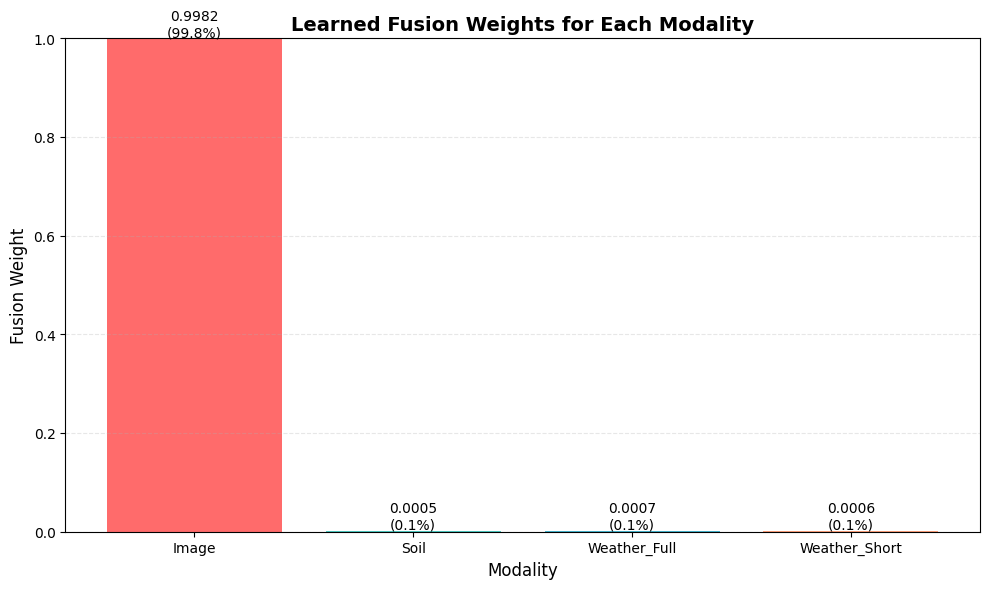

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np

num_classes = train_gen.num_classes  # should be 38

# Inputs: note short weather is 48 timesteps, full is 168
image_input        = keras.Input(shape=(224,224,3), name='image_input')
soil_input         = keras.Input(shape=(x_train_soil.shape[1],), name='soil_input')
weather_short_input= keras.Input(shape=(48, n_features), name='weather_short_input')   # 48h
weather_full_input = keras.Input(shape=(timesteps, n_features), name='weather_full_input')  # 168h

# Raw outputs from your pretrained/defined submodels
image_preds_raw   = mobile_model(image_input)    # (batch, ?)
soil_preds_raw    = soil_model(soil_input)       # (batch, ?)
weather_full_raw  = weather_model(weather_full_input)

def project_to_classes(x, name):
    """Project logits/features to a softmax over num_classes if needed."""
    last_dim = K.int_shape(x)[-1]
    if last_dim is None or last_dim != num_classes:
        return layers.Dense(num_classes, activation='softmax', name=name)(x)
    return layers.Lambda(lambda t: t, name=f'{name}_identity')(x)

# For short weather window build a small projector (LSTM -> Dense -> softmax)
short_x = layers.LSTM(32, return_sequences=False, name='short_lstm')(weather_short_input)
short_x = layers.Dense(64, activation='relu', name='short_fc')(short_x)
weather_short_proj = layers.Dense(num_classes, activation='softmax', name='weather_short_proj')(short_x)

# Project other submodel outputs (if needed) to class probabilities
image_preds = project_to_classes(image_preds_raw,   name='proj_image')
soil_preds  = project_to_classes(soil_preds_raw,    name='proj_soil')
weather_full_preds = project_to_classes(weather_full_raw, name='proj_weather_full')

# LEARNABLE FUSION WEIGHTS
# Create a custom layer that learns the fusion weights
class LearnableFusionWeights(layers.Layer):
    def __init__(self, num_modalities=4, **kwargs):
        super(LearnableFusionWeights, self).__init__(**kwargs)
        self.num_modalities = num_modalities

    def build(self, input_shape):
        # Initialize learnable weights (will be converted to probabilities via softmax)
        self.fusion_weights = self.add_weight(
            name='fusion_weights',
            shape=(self.num_modalities,),
            initializer=keras.initializers.Constant(1.0),  # Start with equal weights
            trainable=True
        )
        super(LearnableFusionWeights, self).build(input_shape)

    def call(self, inputs):
        # inputs is a list: [image_preds, soil_preds, weather_full_preds, weather_short_preds]
        # Apply softmax to ensure weights sum to 1
        normalized_weights = tf.nn.softmax(self.fusion_weights)

        # Stack predictions along a new axis: (batch, num_classes, num_modalities)
        stacked = tf.stack(inputs, axis=-1)

        # Reshape weights for broadcasting: (1, 1, num_modalities)
        weights_reshaped = tf.reshape(normalized_weights, [1, 1, self.num_modalities])

        # Weighted sum: (batch, num_classes)
        weighted_preds = tf.reduce_sum(stacked * weights_reshaped, axis=-1)

        return weighted_preds

    def get_normalized_weights(self):
        """Returns the current normalized fusion weights"""
        return tf.nn.softmax(self.fusion_weights).numpy()

# Apply learnable fusion
fusion_layer = LearnableFusionWeights(num_modalities=4, name='learnable_fusion')
fused_probs = fusion_layer([image_preds, soil_preds, weather_full_preds, weather_short_proj])

fusion_model_4in_dy = keras.Model(
    inputs=[image_input, soil_input, weather_short_input, weather_full_input],
    outputs=fused_probs,
    name='late_fusion_4inputs_learnable'
)

fusion_model_4in_dy.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fusion_model_4in_dy.summary()

# Train the model
fusion4in_dy_history = fusion_model_4in_dy.fit(train_fusion_gen, epochs= 10, validation_data = val_fusion_gen )

# CODE SNIPPET TO GET LEARNED WEIGHTS
def get_fusion_weights(model):
    """
    Extract and display the learned fusion weights from the model.
    Returns a dictionary with modality names and their learned weights.
    """
    # Find the learnable fusion layer
    fusion_layer = None
    for layer in model.layers:
        if isinstance(layer, LearnableFusionWeights):
            fusion_layer = layer
            break

    if fusion_layer is None:
        print("LearnableFusionWeights layer not found!")
        return None

    # Get normalized weights
    weights = fusion_layer.get_normalized_weights()

    # Create a readable dictionary
    modality_names = ['Image', 'Soil', 'Weather_Full', 'Weather_Short']
    weight_dict = {name: float(weight) for name, weight in zip(modality_names, weights)}

    print("\n" + "="*50)
    print("LEARNED FUSION WEIGHTS")
    print("="*50)
    for modality, weight in weight_dict.items():
        print(f"{modality:20s}: {weight:.4f} ({weight*100:.2f}%)")
    print("="*50)
    print(f"Sum of weights: {sum(weight_dict.values()):.6f}")
    print("="*50 + "\n")

    return weight_dict

# After training, get the learned weights
learned_weights = get_fusion_weights(fusion_model_4in_dy)

# You can also visualize the weights
import matplotlib.pyplot as plt

def plot_fusion_weights(weight_dict):
    """Visualize the learned fusion weights as a bar chart"""
    modalities = list(weight_dict.keys())
    weights = list(weight_dict.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(modalities, weights, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
    plt.ylabel('Fusion Weight', fontsize=12)
    plt.xlabel('Modality', fontsize=12)
    plt.title('Learned Fusion Weights for Each Modality', fontsize=14, fontweight='bold')
    plt.ylim([0, 1])

    # Add value labels on top of bars
    for bar, weight in zip(bars, weights):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{weight:.4f}\n({weight*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

# Visualize the weights
plot_fusion_weights(learned_weights)

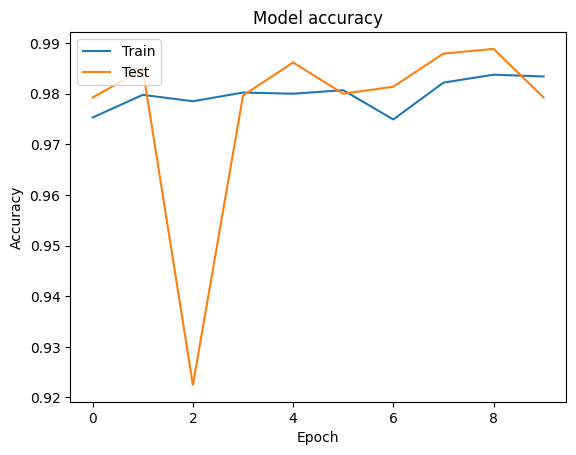

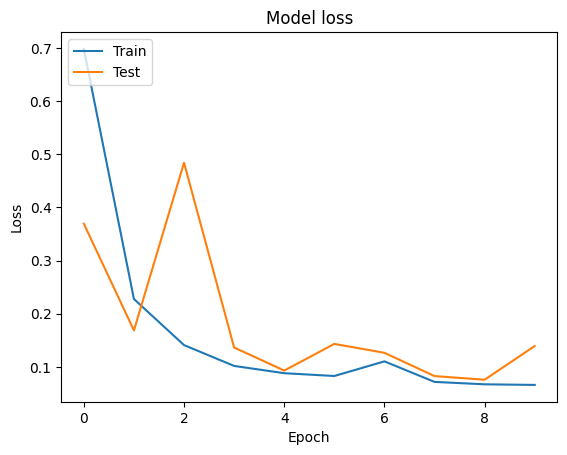

In [56]:
# Plot training & validation accuracy values
plt.plot(fusion4in_dy_history.history['accuracy'])
plt.plot(fusion4in_dy_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(fusion4in_dy_history.history['loss'])
plt.plot(fusion4in_dy_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Fusion Model 2(Actual)

##### Version 2

(image, soil, weather(short), weather (long)) = (0.75,0.1,0.075,0.075)

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np

num_classes = train_gen.num_classes  # should be 38

# Inputs: note short weather is 48 timesteps, full is 168
image_input        = keras.Input(shape=(224,224,3), name='image_input')
soil_input         = keras.Input(shape=(x_train_soil.shape[1],), name='soil_input')
weather_short_input= keras.Input(shape=(48, n_features), name='weather_short_input')   # 48h
weather_full_input = keras.Input(shape=(timesteps, n_features), name='weather_full_input')  # 168h

# Raw outputs from your pretrained/defined submodels
image_preds_raw   = mobile_model(image_input)    # (batch, ?)
soil_preds_raw    = soil_model(soil_input)       # (batch, ?)
# weather_model expects 168 timesteps; use it for full-window
weather_full_raw  = weather_model(weather_full_input)

def project_to_classes(x, name):
    """Project logits/features to a softmax over num_classes if needed."""
    last_dim = K.int_shape(x)[-1]
    if last_dim is None or last_dim != num_classes:
        return layers.Dense(num_classes, activation='softmax', name=name)(x)
    return layers.Lambda(lambda t: t, name=f'{name}_identity')(x)

# For short weather window build a small projector (LSTM -> Dense -> softmax)
short_x = layers.LSTM(32, return_sequences=False, name='short_lstm')(weather_short_input)
short_x = layers.Dense(64, activation='relu', name='short_fc')(short_x)
weather_short_proj = layers.Dense(num_classes, activation='softmax', name='weather_short_proj')(short_x)

# Project other submodel outputs (if needed) to class probabilities
image_preds = project_to_classes(image_preds_raw,   name='proj_image')
soil_preds  = project_to_classes(soil_preds_raw,    name='proj_soil')
weather_full_preds = project_to_classes(weather_full_raw, name='proj_weather_full')

# Choose fixed fusion weights (must sum to 1). Adjust if you prefer different split.
w_img         = 0.75
w_soil        = 0.10
w_weather_full= 0.075
w_weather_short=0.075

# Scale each probability vector (broadcasting)
image_scaled    = layers.Lambda(lambda x: x * w_img,   name='scale_image')(image_preds)
soil_scaled     = layers.Lambda(lambda x: x * w_soil,  name='scale_soil')(soil_preds)
wfull_scaled    = layers.Lambda(lambda x: x * w_weather_full, name='scale_weather_full')(weather_full_preds)
wshort_scaled   = layers.Lambda(lambda x: x * w_weather_short, name='scale_weather_short')(weather_short_proj)

# Element-wise sum of all four projected & scaled class probabilities
fused_probs = layers.Add(name='weighted_sum')([image_scaled, soil_scaled, wfull_scaled, wshort_scaled])

fusion_model_4in_v2 = keras.Model(
    inputs=[image_input, soil_input, weather_short_input, weather_full_input],
    outputs=fused_probs,
    name='late_fusion_4inputs'
)

fusion_model_4in_v2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fusion_model_4in_v2.summary()

Model: "late_fusion_4inputs"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ weather_short_input │ (None, 48, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ soil_input          │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_full_input  │ (None, 168, 11)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ short_lstm (LSTM)   │ (None, 32)        │      5,632 │ weather_short_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 38)        │ 18,610,854 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 38)        │     79,238 │ soil_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 2)         │    147,010 │ weather_full_inp… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ short_fc (Dense)    │ (None, 64)        │      2,112 │ short_lstm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_image_identity │ (None, 38)        │          0 │ sequential[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_soil_identity  │ (None, 38)        │          0 │ functional_1[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_weather_full   │ (None, 38)        │        114 │ sequential_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_short_proj  │ (None, 38)        │      2,470 │ short_fc[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_image         │ (None, 38)        │          0 │ proj_image_ident… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_soil (Lambda) │ (None, 38)        │          0 │ proj_soil_identi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_weather_full  │ (None, 38)        │          0 │ proj_weather_ful… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_weather_short │ (None, 38)        │          0 │ weather_short_pr… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_sum (Add)  │ (None, 38)        │          0 │ scale_image[0][0

 Total params: 18,847,430 (71.90 MB)

 Trainable params: 18,685,878 (71.28 MB)

 Non-trainable params: 161,552 (631.06 KB)

In [47]:
fusion4in_v2_history = fusion_model_4in_v2.fit(train_fusion_gen, epochs=10, validation_data=val_fusion_gen)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1782s 1s/step - accuracy: 0.9748 - loss: 0.3523 - val_accuracy: 0.9731 - val_loss: 0.3681
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1733s 1s/step - accuracy: 0.9714 - loss: 0.3584 - val_accuracy: 0.9328 - val_loss: 0.5806
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1734s 1s/step - accuracy: 0.9773 - loss: 0.3372 - val_accuracy: 0.9707 - val_loss: 0.3936
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1733s 1s/step - accuracy: 0.9687 - loss: 0.3664 - val_accuracy: 0.9390 - val_loss: 0.5533
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1735s 1s/step - accuracy: 0.9765 - loss: 0.3419 - val_accuracy: 0.9393 - val_loss: 0.5699
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1739s 1s/step - accuracy: 0.9704 - loss: 0.3684 - val_accuracy: 0.9699 - val_loss: 0.3995
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1730s 1s/step - accuracy: 0.9746 - loss: 0.3421 - val_accuracy: 0.9785 - val_loss: 0.3512
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1729s 1s/step - accuracy: 0.9772 -

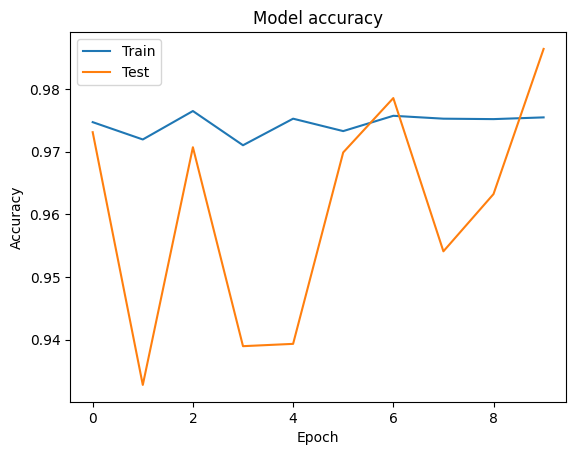

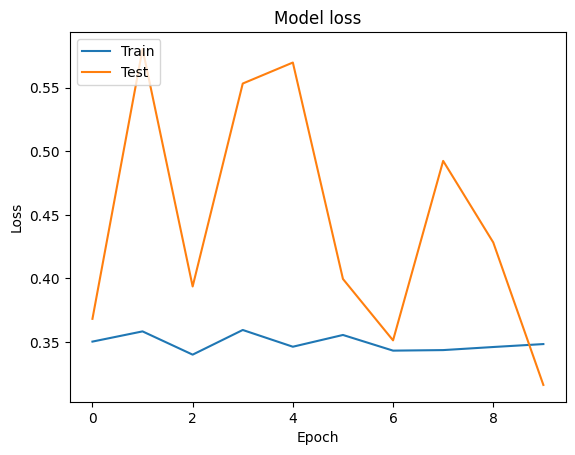

In [48]:
# Plot training & validation accuracy values
plt.plot(fusion4in_v2_history.history['accuracy'])
plt.plot(fusion4in_v2_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(fusion4in_v2_history.history['loss'])
plt.plot(fusion4in_v2_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### Version 3 (Target)

(image, soil, weather(short), weather (long)) = (0.8,0.1,0.05,0.05)

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np

num_classes = train_gen.num_classes  # should be 38

# Inputs: note short weather is 48 timesteps, full is 168
image_input        = keras.Input(shape=(224,224,3), name='image_input')
soil_input         = keras.Input(shape=(x_train_soil.shape[1],), name='soil_input')
weather_short_input= keras.Input(shape=(48, n_features), name='weather_short_input')   # 48h
weather_full_input = keras.Input(shape=(timesteps, n_features), name='weather_full_input')  # 168h

# Raw outputs from your pretrained/defined submodels
image_preds_raw   = mobile_model(image_input)    # (batch, ?)
soil_preds_raw    = soil_model(soil_input)       # (batch, ?)
# weather_model expects 168 timesteps; use it for full-window
weather_full_raw  = weather_model(weather_full_input)

def project_to_classes(x, name):
    """Project logits/features to a softmax over num_classes if needed."""
    last_dim = K.int_shape(x)[-1]
    if last_dim is None or last_dim != num_classes:
        return layers.Dense(num_classes, activation='softmax', name=name)(x)
    return layers.Lambda(lambda t: t, name=f'{name}_identity')(x)

# For short weather window build a small projector (LSTM -> Dense -> softmax)
short_x = layers.LSTM(32, return_sequences=False, name='short_lstm')(weather_short_input)
short_x = layers.Dense(64, activation='relu', name='short_fc')(short_x)
weather_short_proj = layers.Dense(num_classes, activation='softmax', name='weather_short_proj')(short_x)

# Project other submodel outputs (if needed) to class probabilities
image_preds = project_to_classes(image_preds_raw,   name='proj_image')
soil_preds  = project_to_classes(soil_preds_raw,    name='proj_soil')
weather_full_preds = project_to_classes(weather_full_raw, name='proj_weather_full')

# Choose fixed fusion weights (must sum to 1). Adjust if you prefer different split.
w_img         = 0.80
w_soil        = 0.10
w_weather_full= 0.05
w_weather_short=0.05

# Scale each probability vector (broadcasting)
image_scaled    = layers.Lambda(lambda x: x * w_img,   name='scale_image')(image_preds)
soil_scaled     = layers.Lambda(lambda x: x * w_soil,  name='scale_soil')(soil_preds)
wfull_scaled    = layers.Lambda(lambda x: x * w_weather_full, name='scale_weather_full')(weather_full_preds)
wshort_scaled   = layers.Lambda(lambda x: x * w_weather_short, name='scale_weather_short')(weather_short_proj)

# Element-wise sum of all four projected & scaled class probabilities
fused_probs = layers.Add(name='weighted_sum')([image_scaled, soil_scaled, wfull_scaled, wshort_scaled])

fusion_model_4in = keras.Model(
    inputs=[image_input, soil_input, weather_short_input, weather_full_input],
    outputs=fused_probs,
    name='late_fusion_4inputs'
)

fusion_model_4in.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fusion_model_4in.summary()

Model: "late_fusion_4inputs"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ weather_short_input │ (None, 48, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ soil_input          │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_full_input  │ (None, 168, 11)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ short_lstm (LSTM)   │ (None, 32)        │      5,632 │ weather_short_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 38)        │ 18,610,854 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 38)        │     79,238 │ soil_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 2)         │    147,010 │ weather_full_inp… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ short_fc (Dense)    │ (None, 64)        │      2,112 │ short_lstm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_image_identity │ (None, 38)        │          0 │ sequential[1][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_soil_identity  │ (None, 38)        │          0 │ functional_1[1][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_weather_full   │ (None, 38)        │        114 │ sequential_1[1][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_short_proj  │ (None, 38)        │      2,470 │ short_fc[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_image         │ (None, 38)        │          0 │ proj_image_ident… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_soil (Lambda) │ (None, 38)        │          0 │ proj_soil_identi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_weather_full  │ (None, 38)        │          0 │ proj_weather_ful… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_weather_short │ (None, 38)        │          0 │ weather_short_pr… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_sum (Add)  │ (None, 38)        │          0 │ scale_image[0][0

 Total params: 18,847,430 (71.90 MB)

 Trainable params: 18,685,878 (71.28 MB)

 Non-trainable params: 161,552 (631.06 KB)

In [50]:
fusion4in_history = fusion_model_4in.fit(train_fusion_gen, epochs=10, validation_data=val_fusion_gen)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1763s 1s/step - accuracy: 0.9768 - loss: 0.2873 - val_accuracy: 0.9572 - val_loss: 0.4056
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1724s 1s/step - accuracy: 0.9756 - loss: 0.2864 - val_accuracy: 0.9778 - val_loss: 0.3052
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1730s 1s/step - accuracy: 0.9768 - loss: 0.2843 - val_accuracy: 0.9881 - val_loss: 0.2628
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1733s 1s/step - accuracy: 0.9778 - loss: 0.2774 - val_accuracy: 0.9836 - val_loss: 0.2781
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1733s 1s/step - accuracy: 0.9701 - loss: 0.3179 - val_accuracy: 0.9771 - val_loss: 0.3203
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1733s 1s/step - accuracy: 0.9775 - loss: 0.2828 - val_accuracy: 0.9605 - val_loss: 0.4138
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1733s 1s/step - accuracy: 0.9783 - loss: 0.2767 - val_accuracy: 0.9747 - val_loss: 0.3273
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1733s 1s/step - accuracy: 0.9814 -

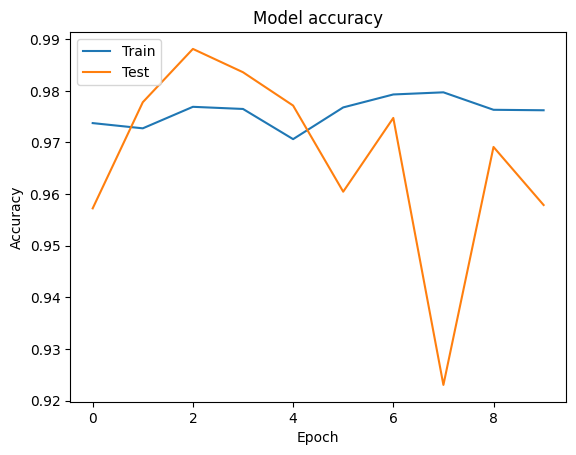

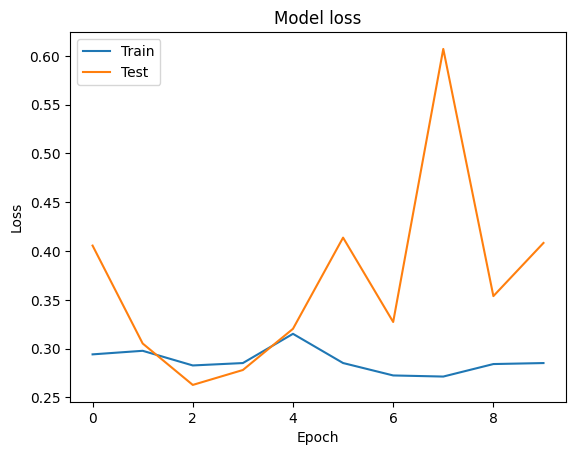

In [51]:
# Plot training & validation accuracy values
plt.plot(fusion4in_history.history['accuracy'])
plt.plot(fusion4in_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(fusion4in_history.history['loss'])
plt.plot(fusion4in_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### Version 4


(image, soil, weather(short), weather (long)) = (0.90,0.05,0.025,0.025)

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np

num_classes = train_gen.num_classes  # should be 38

# Inputs: note short weather is 48 timesteps, full is 168
image_input        = keras.Input(shape=(224,224,3), name='image_input')
soil_input         = keras.Input(shape=(x_train_soil.shape[1],), name='soil_input')
weather_short_input= keras.Input(shape=(48, n_features), name='weather_short_input')   # 48h
weather_full_input = keras.Input(shape=(timesteps, n_features), name='weather_full_input')  # 168h

# Raw outputs from your pretrained/defined submodels
image_preds_raw   = mobile_model(image_input)    # (batch, ?)
soil_preds_raw    = soil_model(soil_input)       # (batch, ?)
# weather_model expects 168 timesteps; use it for full-window
weather_full_raw  = weather_model(weather_full_input)

def project_to_classes(x, name):
    """Project logits/features to a softmax over num_classes if needed."""
    last_dim = K.int_shape(x)[-1]
    if last_dim is None or last_dim != num_classes:
        return layers.Dense(num_classes, activation='softmax', name=name)(x)
    return layers.Lambda(lambda t: t, name=f'{name}_identity')(x)

# For short weather window build a small projector (LSTM -> Dense -> softmax)
short_x = layers.LSTM(32, return_sequences=False, name='short_lstm')(weather_short_input)
short_x = layers.Dense(64, activation='relu', name='short_fc')(short_x)
weather_short_proj = layers.Dense(num_classes, activation='softmax', name='weather_short_proj')(short_x)

# Project other submodel outputs (if needed) to class probabilities
image_preds = project_to_classes(image_preds_raw,   name='proj_image')
soil_preds  = project_to_classes(soil_preds_raw,    name='proj_soil')
weather_full_preds = project_to_classes(weather_full_raw, name='proj_weather_full')

# Choose fixed fusion weights (must sum to 1). Adjust if you prefer different split.
w_img         = 0.90
w_soil        = 0.05
w_weather_full= 0.025
w_weather_short=0.025

# Scale each probability vector (broadcasting)
image_scaled    = layers.Lambda(lambda x: x * w_img,   name='scale_image')(image_preds)
soil_scaled     = layers.Lambda(lambda x: x * w_soil,  name='scale_soil')(soil_preds)
wfull_scaled    = layers.Lambda(lambda x: x * w_weather_full, name='scale_weather_full')(weather_full_preds)
wshort_scaled   = layers.Lambda(lambda x: x * w_weather_short, name='scale_weather_short')(weather_short_proj)

# Element-wise sum of all four projected & scaled class probabilities
fused_probs = layers.Add(name='weighted_sum')([image_scaled, soil_scaled, wfull_scaled, wshort_scaled])

fusion_model_4in_v4 = keras.Model(
    inputs=[image_input, soil_input, weather_short_input, weather_full_input],
    outputs=fused_probs,
    name='late_fusion_4inputs'
)

fusion_model_4in_v4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fusion_model_4in_v4.summary()

Model: "late_fusion_4inputs"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ weather_short_input │ (None, 48, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ soil_input          │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_full_input  │ (None, 168, 11)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ short_lstm (LSTM)   │ (None, 32)        │      5,632 │ weather_short_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 38)        │ 18,610,854 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 38)        │     79,238 │ soil_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 2)         │    147,010 │ weather_full_inp… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ short_fc (Dense)    │ (None, 64)        │      2,112 │ short_lstm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_image_identity │ (None, 38)        │          0 │ sequential[2][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_soil_identity  │ (None, 38)        │          0 │ functional_1[2][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_weather_full   │ (None, 38)        │        114 │ sequential_1[2][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_short_proj  │ (None, 38)        │      2,470 │ short_fc[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_image         │ (None, 38)        │          0 │ proj_image_ident… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_soil (Lambda) │ (None, 38)        │          0 │ proj_soil_identi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_weather_full  │ (None, 38)        │          0 │ proj_weather_ful… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_weather_short │ (None, 38)        │          0 │ weather_short_pr… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_sum (Add)  │ (None, 38)        │          0 │ scale_image[0][0

 Total params: 18,847,430 (71.90 MB)

 Trainable params: 18,685,878 (71.28 MB)

 Non-trainable params: 161,552 (631.06 KB)

In [53]:
fusion4in_v4_history = fusion_model_4in_v4.fit(train_fusion_gen, epochs=10, validation_data=val_fusion_gen)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1740s 1s/step - accuracy: 0.9783 - loss: 0.1774 - val_accuracy: 0.9685 - val_loss: 0.2693
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1693s 1s/step - accuracy: 0.9757 - loss: 0.1881 - val_accuracy: 0.9866 - val_loss: 0.1623
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1700s 1s/step - accuracy: 0.9790 - loss: 0.1709 - val_accuracy: 0.9878 - val_loss: 0.1584
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1704s 1s/step - accuracy: 0.9792 - loss: 0.1691 - val_accuracy: 0.9822 - val_loss: 0.1857
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1692s 1s/step - accuracy: 0.9792 - loss: 0.1739 - val_accuracy: 0.9796 - val_loss: 0.1988
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1692s 1s/step - accuracy: 0.9774 - loss: 0.1770 - val_accuracy: 0.9811 - val_loss: 0.1925
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1690s 1s/step - accuracy: 0.9794 - loss: 0.1709 - val_accuracy: 0.8687 - val_loss: 0.7501
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1695s 1s/step - accuracy: 0.9739 -

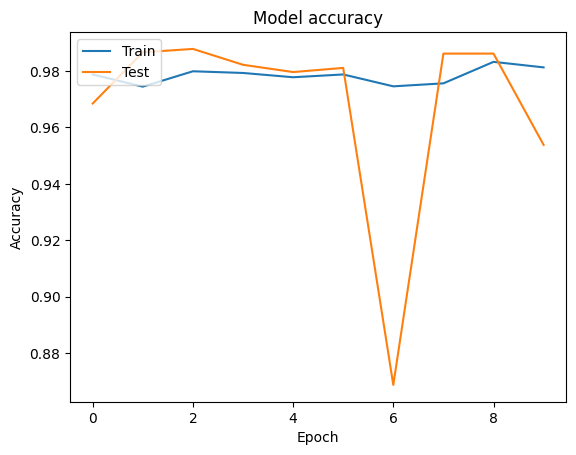

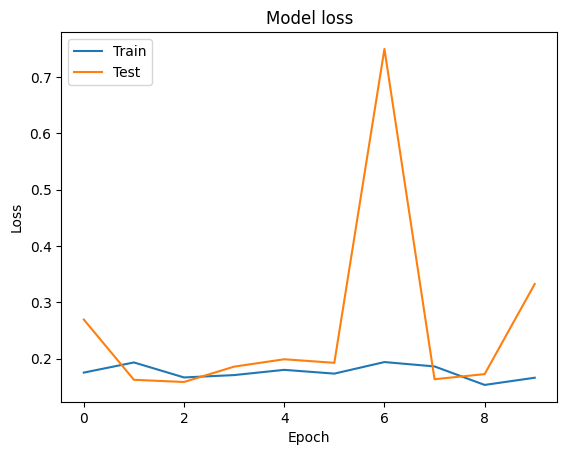

In [54]:
# Plot training & validation accuracy values
plt.plot(fusion4in_v4_history.history['accuracy'])
plt.plot(fusion4in_v4_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(fusion4in_v4_history.history['loss'])
plt.plot(fusion4in_v4_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [57]:
fusion_model_4in.save('fusion_model_4in.h5')

##### classification report

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import json
import matplotlib.pyplot as plt
import seaborn as sns

# change these if different
model = fusion_model_4in      # or fusion_model_fixed if that's the trained model
val_gen = val_fusion_gen
class_names = DISEASE_LIST    # list of class names in correct order (len == num_classes)
num_classes = len(class_names)

# 1) Predict on the entire validation set (uses Sequence API)
print("Running model.predict on validation generator...")
y_pred_proba = model.predict(val_gen, verbose=1)  # shape (N_samples, num_classes) expected

# If the model returned logits (no softmax), convert with softmax:
if y_pred_proba.ndim == 2 and not np.allclose(y_pred_proba.sum(axis=1), 1.0, atol=1e-3):
    # apply softmax safely
    exp = np.exp(y_pred_proba - np.max(y_pred_proba, axis=1, keepdims=True))
    y_pred_proba = exp / exp.sum(axis=1, keepdims=True)

y_pred = np.argmax(y_pred_proba, axis=1)

# 2) Collect true labels from the validation generator
print("Collecting ground-truth labels from the generator...")
y_true_list = []
for i in range(len(val_gen)):
    _, labels = val_gen[i]  # indexing a Sequence is safe
    labels = np.asarray(labels)
    if labels.ndim > 1:                 # one-hot -> class index
        labels = np.argmax(labels, axis=1)
    y_true_list.append(labels)

y_true = np.concatenate(y_true_list, axis=0)

# Sanity check: lengths must match
if y_true.shape[0] != y_pred.shape[0]:
    raise ValueError(f"Length mismatch: y_true={y_true.shape[0]} vs y_pred={y_pred.shape[0]}."
                     " Make sure val_gen length and model.predict used same steps/ordering.")

# 3) Compute metrics
acc = accuracy_score(y_true, y_pred)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Macro  Precision: {precision_macro:.4f}  Recall: {recall_macro:.4f}  F1: {f1_macro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}  Recall: {recall_weighted:.4f}  F1: {f1_weighted:.4f}")

# 4) Per-class classification report (as text)
report_text = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print("\nPer-class classification report:\n")
print(report_text)

# 5) Save report as CSV & JSON for later inspection
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('classification_report.csv', index=True)
with open('classification_report.json', 'w') as f:
    json.dump(report_dict, f, indent=2)

print("Saved classification_report.csv and classification_report.json to current directory.")

# Confusion matrix plotting (corrected)
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-12)

# Save CSVs
pd.DataFrame(cm, index=class_names, columns=class_names).to_csv('confusion_matrix_raw.csv')
pd.DataFrame(cm_norm, index=class_names, columns=class_names).to_csv('confusion_matrix_normalized.csv')

# Plot (bigger figure, rotated labels for readability)
plt.figure(figsize=(18, 14))                       # larger for 38 classes
sns.heatmap(cm_norm, xticklabels=class_names, yticklabels=class_names,
            cmap='Blues', annot=False, fmt='.2f')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=90)    # rotate x labels
plt.yticks(rotation=0)     # keep y labels horizontal
plt.tight_layout()         # CORRECT function — was the accidental 'plt.t' earlier
plt.savefig('confusion_matrix_normalized.png', dpi=200)
plt.show()

NameError: name 'fusion_model_4in' is not defined

#### Fusion Model 3 (variance and callback based)

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class VarianceGating(layers.Layer):
    """
    Computes feature variance and determines if support is needed
    """
    def __init__(self, threshold_type='learned', name='variance_gating', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold_type = threshold_type
        self.running_baseline = None
        self.step_count = 0

    def build(self, input_shape):
        if self.threshold_type == 'learned':
            # Learnable threshold parameter
            self.threshold = self.add_weight(
                name='threshold',
                shape=(),
                initializer='zeros',
                trainable=True
            )

        # Store baseline statistics
        self.baseline_mean = self.add_weight(
            name='baseline_mean',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=False
        )

        super().build(input_shape)

    def call(self, inputs, training=None):
        # Calculate feature-wise variance
        feature_variance = tf.reduce_mean(tf.square(inputs - tf.reduce_mean(inputs, axis=-1, keepdims=True)), axis=-1)

        # Update running baseline during training
        if training:
            self.step_count += 1
            alpha = 1.0 / tf.cast(self.step_count, tf.float32)  # Decreasing learning rate for baseline
            current_mean = tf.reduce_mean(inputs, axis=0)
            self.baseline_mean.assign(
                (1 - alpha) * self.baseline_mean + alpha * current_mean
            )

        # Calculate variance relative to baseline
        baseline_variance = tf.reduce_mean(tf.square(inputs - self.baseline_mean), axis=-1)
        relative_variance = feature_variance / (baseline_variance + 1e-8)

        # Gate signal (1.0 = need support, 0.0 = no support needed)
        if self.threshold_type == 'learned':
            gate_signal = tf.sigmoid(relative_variance - self.threshold)
        else:
            gate_signal = tf.cast(relative_variance > 0.5, tf.float32)  # Default threshold

        return {
            'features': inputs,
            'variance': feature_variance,
            'relative_variance': relative_variance,
            'gate_signal': gate_signal,
            'needs_support': tf.reduce_mean(gate_signal)  # Batch-level support indicator
        }

class ProportionalFusion(layers.Layer):
    """
    Learns optimal proportional reduction and fusion of features
    """
    def __init__(self, output_dim, name='proportional_fusion', **kwargs):
        super().__init__(name=name, **kwargs)
        self.output_dim = output_dim

    def build(self, input_shapes):
        # input_shapes should be [primary_shape, support_shape]
        primary_dim = input_shapes[0][-1]
        support_dim = input_shapes[1][-1]

        # Learnable projection matrices for each input
        self.primary_projection = self.add_weight(
            name='primary_projection',
            shape=(primary_dim, self.output_dim),
            initializer='glorot_uniform',
            trainable=True
        )

        self.support_projection = self.add_weight(
            name='support_projection',
            shape=(support_dim, self.output_dim),
            initializer='glorot_uniform',
            trainable=True
        )

        # Learnable fusion weights
        self.fusion_weights = self.add_weight(
            name='fusion_weights',
            shape=(2,),  # [primary_weight, support_weight]
            initializer='constant',
            initializer_value=[0.8, 0.2],  # Start with image dominance
            trainable=True
        )

        super().build(input_shapes)

    def call(self, inputs, gate_signal=None):
        primary_features, support_features = inputs

        # Project both to same dimensionality
        primary_projected = tf.matmul(primary_features, self.primary_projection)
        support_projected = tf.matmul(support_features, self.support_projection)

        # Normalize fusion weights
        normalized_weights = tf.nn.softmax(self.fusion_weights)

        # Apply gating if provided
        if gate_signal is not None:
            # Modulate support weight based on gate signal
            gate_signal = tf.expand_dims(gate_signal, -1)  # Shape for broadcasting
            effective_support_weight = normalized_weights[1] * gate_signal
            effective_primary_weight = normalized_weights[0] + (normalized_weights[1] - effective_support_weight)

            fused_features = (effective_primary_weight * primary_projected +
                            effective_support_weight * support_projected)
        else:
            # Standard weighted combination
            fused_features = (normalized_weights[0] * primary_projected +
                            normalized_weights[1] * support_projected)

        return fused_features

class MultiLayerFeatureExtractor(layers.Layer):
    """
    Extracts features from multiple layers of a support network
    """
    def __init__(self, target_layers=None, name='multi_layer_extractor', **kwargs):
        super().__init__(name=name, **kwargs)
        self.target_layers = target_layers or [-1]  # Default to last layer

    def call(self, model, inputs):
        """
        Extract features from specified layers of the model
        """
        extracted_features = {}

        # Get intermediate outputs
        x = inputs
        for i, layer in enumerate(model.layers):
            x = layer(x)
            if i in self.target_layers or layer.name in self.target_layers:
                extracted_features[f'layer_{i}_{layer.name}'] = x

        # If no specific layers found, return final output
        if not extracted_features:
            extracted_features['final'] = x

        return extracted_features

class ProgressiveFusionModel(keras.Model):
    """
    Main fusion model implementing your progressive architecture
    """
    def __init__(self, image_model, soil_model, weather_model, num_classes, **kwargs):
        super().__init__(**kwargs)

        # Store original models (frozen for feature extraction)
        self.image_backbone = image_model
        self.soil_backbone = soil_model
        self.weather_backbone = weather_model
        self.num_classes = num_classes

        # Variance gating layers
        self.gate_256 = VarianceGating(name='gate_256')
        self.gate_64 = VarianceGating(name='gate_64')

        # Fusion layers
        self.soil_fusion = ProportionalFusion(128, name='soil_fusion')  # After Dense(256) -> Dense(128)
        self.weather_fusion = ProportionalFusion(64, name='weather_fusion')  # After Dense(128) -> Dense(64)

        # Feature extractors for support networks
        self.soil_extractor = MultiLayerFeatureExtractor([2, 4, 6])  # Multiple soil layers
        self.weather_extractor = MultiLayerFeatureExtractor([2, 4, 6])  # Multiple weather layers

        # Final classification heads
        self.fusion_classifier = layers.Dense(num_classes, activation='softmax', name='fusion_prediction')

        # Auxiliary heads for multi-task learning
        self.image_classifier = layers.Dense(num_classes, activation='softmax', name='image_prediction')
        self.soil_classifier = layers.Dense(num_classes, activation='softmax', name='soil_prediction')
        self.weather_classifier = layers.Dense(num_classes, activation='softmax', name='weather_prediction')

    def call(self, inputs, training=None):
        """
        Progressive fusion forward pass
        """
        image_input, soil_input, weather_short_input, weather_full_input = inputs

        outputs = {}

        # === IMAGE PROCESSING WITH FUSION POINTS ===

        # Process through image backbone until Dense(256)
        x = image_input
        found_256 = False
        found_64 = False

        for i, layer in enumerate(self.image_backbone.layers):
            x = layer(x)

            # First fusion point - after Dense(256)
            if isinstance(layer, layers.Dense) and layer.units == 256 and not found_256:
                found_256 = True
                # Variance gating
                gate_info = self.gate_256(x, training=training)
                image_256_features = gate_info['features']
                gate_signal_256 = gate_info['gate_signal']

                # Extract soil features if support needed
                needs_support = tf.reduce_mean(gate_info['needs_support'])

                def extract_and_fuse_soil():
                    soil_features = self.soil_extractor(soil_input)
                    return self.soil_fusion([image_256_features, soil_features], gate_signal_256)

                def use_image_only():
                    return image_256_features

                # Conditional fusion based on support need
                x = tf.cond(
                    needs_support > 0.1,  # Threshold for calling support
                    extract_and_fuse_soil,
                    use_image_only
                )
                outputs['soil_support_used'] = needs_support > 0.1

            # Second fusion point - after Dense(64)
            if isinstance(layer, layers.Dense) and layer.units == 64 and not found_64:
                found_64 = True
                # Variance gating for weather support
                gate_info = self.gate_64(x, training=training)
                current_features = gate_info['features']
                gate_signal_64 = gate_info['gate_signal']

                # Weather support decision
                needs_support = tf.reduce_mean(gate_info['needs_support'])
                uncertainty_level = tf.reduce_mean(gate_info['relative_variance'])

                def extract_and_fuse_weather():
                    # Choose weather input based on uncertainty
                    weather_input = tf.cond(
                        uncertainty_level > 1.5,
                        lambda: weather_full_input,  # 168h for high uncertainty
                        lambda: weather_short_input  # 48h for moderate uncertainty
                    )
                    weather_features = self.weather_extractor(weather_input)
                    return self.weather_fusion([current_features, weather_features], gate_signal_64)

                def use_current_only():
                    return current_features

                # Conditional weather fusion
                x = tf.cond(
                    needs_support > 0.15,  # Higher threshold for weather
                    extract_and_fuse_weather,
                    use_current_only
                )
                outputs['weather_support_used'] = needs_support > 0.15
                outputs['uncertainty_level'] = uncertainty_level

        # Final fusion prediction
        fusion_logits = self.fusion_classifier(x)
        outputs['fusion_prediction'] = fusion_logits

        # === AUXILIARY PREDICTIONS ===

        # Individual network predictions for comparison
        image_final = self.image_backbone(image_input)
        soil_final = self.soil_extractor(soil_input)
        soil_final = self.soil_classifier(soil_final)
        weather_final = self.weather_extractor(weather_short_input)
        weather_final = self.weather_classifier(weather_final)

        outputs['image_prediction'] = image_final
        outputs['soil_prediction'] = soil_final
        outputs['weather_prediction'] = weather_final

        return outputs

# Loss function for multi-task learning
class ProgressiveFusionLoss(keras.losses.Loss):
    """
    Custom loss that balances fusion prediction with auxiliary losses
    """
    def __init__(self, fusion_weight=1.0, aux_weight=0.3, name='progressive_fusion_loss'):
        super().__init__(name=name)
        self.fusion_weight = fusion_weight
        self.aux_weight = aux_weight
        self.base_loss = keras.losses.CategoricalCrossentropy()

    def call(self, y_true, y_pred):
        # Main fusion loss
        fusion_loss = self.base_loss(y_true, y_pred['fusion_prediction'])

        # Auxiliary losses (for regularization)
        image_loss = self.base_loss(y_true, y_pred['image_prediction'])
        soil_loss = self.base_loss(y_true, y_pred['soil_prediction'])
        weather_loss = self.base_loss(y_true, y_pred['weather_prediction'])

        # Combined loss
        total_loss = (self.fusion_weight * fusion_loss +
                     self.aux_weight * (image_loss + soil_loss + weather_loss) / 3)

        return total_loss

# Example usage and setup
def create_fusion_model(image_model, soil_model, weather_model, num_classes):
    """
    Creates and compiles the complete fusion model
    """

    # Create the fusion model
    fusion_model = ProgressiveFusionModel(
        image_model=image_model,
        soil_model=soil_model,
        weather_model=weather_model,
        num_classes=num_classes
    )

    # Compile with custom loss
    fusion_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=ProgressiveFusionLoss(),
        metrics=['accuracy']
    )

    return fusion_model

# Training setup function
def setup_progressive_training(fusion_model, train_gen, val_gen, epochs=50):
    """
    Setup training with callbacks for monitoring fusion behavior
    """

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            'best_fusion_model.keras', save_best_only=True, monitor='val_loss'
        )
    ]

    # Train the model
    history = fusion_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Usage example:
"""
# Assuming you have your trained individual models
fusion_model = create_fusion_model(
    image_model=your_mobile_model,
    soil_model=your_soil_model,
    weather_model=your_weather_model,
    num_classes=your_num_classes
)

# Setup your synchronized data generators (using your existing code)
train_gen, val_gen = setup_fusion_training(
    train_image_gen, val_image_gen,
    X_soil_train, w_train_gen,
    X_soil_val, w_val_gen
)

# Train the fusion model
history = setup_progressive_training(fusion_model, train_gen, val_gen)
"""

'\n# Assuming you have your trained individual models\nfusion_model = create_fusion_model(\n    image_model=your_mobile_model,\n    soil_model=your_soil_model,\n    weather_model=your_weather_model,\n    num_classes=your_num_classes\n)\n\n# Setup your synchronized data generators (using your existing code)\ntrain_gen, val_gen = setup_fusion_training(\n    train_image_gen, val_image_gen,\n    X_soil_train, w_train_gen,\n    X_soil_val, w_val_gen\n)\n\n# Train the fusion model\nhistory = setup_progressive_training(fusion_model, train_gen, val_gen)\n'

In [59]:
fusion_model = create_fusion_model(
    image_model=mobile_model,
    soil_model=soil_model,
    weather_model=weather_model,
    num_classes=38
)

In [60]:
x_batch, y_batch = train_fusion_gen[0]
print("input shapes:", [getattr(x,'shape',None) for x in x_batch])
print("y shape:", y_batch.shape)

preds = fusion_model(x_batch, training=True)
print("model returned type:", type(preds))
for i,p in enumerate(preds):
    print(f" pred[{i}] shape:", getattr(p,'shape',None))


input shapes: [(32, 224, 224, 3), (32, 8), (32, 48, 11), (32, 168, 11)]
y shape: (32, 38)


TypeError: Exception encountered when calling ProgressiveFusionModel.call().

[1mmissing a required argument: 'inputs'[0m

Arguments received by ProgressiveFusionModel.call():
  • inputs=('tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)', 'tf.Tensor(shape=(32, 8), dtype=float32)', 'tf.Tensor(shape=(32, 48, 11), dtype=float32)', 'tf.Tensor(shape=(32, 168, 11), dtype=float32)')
  • training=True

In [ ]:
history = setup_progressive_training(fusion_model, train_fusion_gen, val_fusion_gen, epochs=50)

In [ ]:
fusion_model = create_fusion_model(
    image_model=mobile_model,
    soil_model=soil_model,
    weather_model=weather_model,
    num_classes=38
)

In [ ]:
# Now you can train your Fusion Model 3 with the generator
history = fusion_model.fit(
    train_fusion_gen,
    validation_data=val_fusion_gen,
    epochs=50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint('best_fusion_model.keras', save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)